<a href="https://colab.research.google.com/github/CedrikCampeau31/STATS_SPORTS/blob/main/NHL_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. **Récupérer et préparer les données (ETL)**  
   - On va prendre les stats des joueurs pour les saisons 2022-2023, 2023-2024 et 2024-2025.  
   - Étapes: extraction → nettoyage → intégration dans un seul dataset.

2. **Exploration et nettoyage (EDA)**  
   - Regarder la qualité des données (valeurs manquantes, incohérences).  
   - Vérifier les distributions (histogrammes, stats descriptives).  
   - Créer des variables utiles comme les points = buts + passes.

3. **Petites hypothèses/stat tests**  
   - Exemple: est-ce que le temps de glace influence vraiment les points ?  
   - Est-ce que certaines positions produisent plus que d’autres ?  
   - Ces tests servent juste à nous donner une intuition, sans tricher avec le set de test.

4. **Sélection des variables (features)**  
   - Regarder les corrélations.  
   - Calculer l’information mutuelle (voir quelles variables expliquent bien les points).  
   - Importance des features via permutation.  
   - Vérifier la colinéarité si besoin (VIF).

5. **Pipeline ML (scikit-learn)**  
   - Splitter en train / validation / test.  
   - Prétraitements (imputation des valeurs manquantes, encodage des catégories).  
   - Modèle (RandomForest pour commencer).  
   - Mesurer les performances avec MAE, RMSE, R².  
   - Sauvegarder le pipeline pour réutilisation.

6. **Prédictions saison suivante (2026)**  
   - Utiliser les stats de 2024-2025 comme features d’entrée.  
   - Générer les prédictions de points pour 2025-2026 (pré-saison).

In [97]:
# =========================
# Étape 1 — Chargement & nettoyage (Colab-ready)
# =========================
import pandas as pd
import numpy as np
import re

PATH_XLSX = "https://raw.githubusercontent.com/CedrikCampeau31/STATS_SPORTS/main/STATS_NHL_ALL_19_25.xlsx"
df_raw = pd.read_excel(PATH_XLSX, sheet_name=0, skiprows=1, engine="openpyxl")

print("Shape brut:", df_raw.shape)
print("Aperçu colonnes brutes:", list(df_raw.columns))

df = df_raw.copy()

# --- Renommer / harmoniser (basé sur TA LISTE EXACTE) ---
rename_map = {
    "Rk": "rank",
    "Name": "playerName",
    "Team": "team",
    "Age": "age",
    "Pos": "pos",
    "GP": "gp",
    "G": "g",
    "A": "a",
    "P": "pts",
    "PIM": "pim",
    "+/-": "pm",
    "TOI": "toi",         # HH:MM:SS ou MM:SS
    "ES": "es_pts",       # points à 5v5 (si c'est bien ça dans ton fichier)
    "PP": "pp_pts",
    "SH": "sh_pts",

    "ESG": "esg",
    "PPG": "ppg",
    "SHG": "shg",
    "GWG": "gwg",
    "OTG": "otg",

    "ESA": "esa",
    "PPA": "ppa",
    "SHA": "sha",
    "GWA": "gwa",
    "OTA": "ota",

    "ESP": "esp",
    "PPP": "ppp",
    "SHP": "shp",
    "GWP": "gwp",
    "OTP": "otp",

    "PPP%": "ppp_pct",

    "G/60": "g_per60",
    "A/60": "a_per60",
    "P/60": "p_per60",
    "ESG/60": "esg_per60",
    "ESA/60": "esa_per60",
    "ESP/60": "esp_per60",
    "PPG/60": "ppg_per60",
    "PPA/60": "ppa_per60",
    "PPP/60": "ppp_per60",

    "G/GP": "g_pergp",
    "A/GP": "a_pergp",
    "P/GP": "p_pergp",

    "SHOTS": "shots",
    "SH%": "sh_pct",
    "HITS": "hits",
    "BS": "blocks",
    "FOW": "fow",
    "FOL": "fol",
    "FO%": "fo_pct",

    # Si ta feuille a "Season" / "season", on normalisera plus bas aussi
    "Season": "seasonId",
}
df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns}, inplace=True)

# --- Garder un large sous-ensemble cohérent ---
keep_cols = [c for c in [
    "rank","playerName","team","age","pos","seasonId",
    "gp","g","a","pts","pim","pm","toi","es_pts","pp_pts","sh_pts",
    "esg","ppg","shg","gwg","otg","esa","ppa","sha","gwa","ota","esp","ppp","shp","gwp","otp",
    "ppp_pct",
    "g_per60","a_per60","p_per60","esg_per60","esa_per60","esp_per60","ppg_per60","ppa_per60","ppp_per60",
    "g_pergp","a_pergp","p_pergp",
    "shots","sh_pct","hits","blocks","fow","fol","fo_pct"
] if c in df.columns]
df = df[keep_cols].copy()

# --- Handle 'seasonId' column: fill NaN and convert to integer ---
if 'seasonId' in df.columns:
    df['seasonId'] = df['seasonId'].fillna(0).astype(int)


# --- Pourcentages en numériques ---
for pct_col in ["sh_pct", "fo_pct", "ppp_pct"]:
    if pct_col in df.columns:
        # gère "12.3%" ou "12.3"
        df[pct_col] = pd.to_numeric(df[pct_col].astype(str).str.replace('%','', regex=False), errors='coerce')

# --- Numérisation sûre ---
num_cols = [c for c in df.columns if c not in ["playerName","team","pos","toi","seasonId"]]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# --- TOI (total saison) → minutes décimales ---
def toi_to_minutes(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float)): return float(x)
    s = str(x)
    # HH:MM:SS
    if re.match(r"^\d{1,2}:\d{2}:\d{2}$", s):
        h, m, sec = s.split(":")
        return int(h)*60 + int(m) + int(sec)/60.0
    # MM:SS
    if re.match(r"^\d{1,3}:\d{2}$", s):
        m, sec = s.split(":")
        return int(m) + int(sec)/60.0
    return np.nan

if "toi" in df.columns:
    df["toi_min_total"] = df["toi"].apply(toi_to_minutes)

# --- Nettoyage simple ---
if "team" in df.columns:
    df["team"] = df["team"].astype(str).str.strip().str.upper()
if "pos" in df.columns:
    df["pos"]  = df["pos"].astype(str).str.strip().str.upper()

df = df.dropna(subset=["playerName","team"])  # essentiels
df = df[df["gp"].fillna(0) >= 0]

print("Shape nettoyé:", df.shape)
# display(df.head(10)) # (optionnel en notebook)

# =========================
# PATCH v2 — normaliser seasonId + créer seasonId_prev + features prev/deltas
# =========================

def _find_col(df, candidates):
    # matching robuste: ignore casse / espaces / underscores
    norm = {re.sub(r'[\s_]+','', str(c)).lower(): c for c in df.columns}
    for cand in candidates:
        key = re.sub(r'[\s_]+','', cand).lower()
        if key in norm:
            return norm[key]
    # fallback "contient"
    for cand in candidates:
        key = re.sub(r'[\s_]+','', cand).lower()
        for k, orig in norm.items():
            if key in k:
                return orig
    return None

def ensure_season_cols(df: pd.DataFrame):
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]

    # 1) Saisir/normaliser la saison
    season_col = _find_col(df, ['seasonId','season_id','season','Season'])
    if season_col is None:
        raise ValueError("Pas de colonne saison trouvée (season/seasonId).")
    if season_col != 'seasonId':
        df = df.rename(columns={season_col: 'seasonId'})

    # si la saison est du texte type "2021-22", on la laisse telle quelle;
    # sinon on tente la conversion numérique sans casser
    try:
        df['seasonId'] = pd.to_numeric(df['seasonId'], errors='ignore')
    except Exception:
        pass

    # 2) Identifiant joueur (inclut 'playerName' post-rename)
    player_col = _find_col(df, [
        'playerId','player_id','skaterId','nhlId',
        'playerName','Player Name','Name','name','player'
    ])
    if player_col is None:
        raise ValueError(
            "Aucun identifiant joueur trouvé (ex. playerId, playerName, Name). "
            f"Colonnes vues: {list(df.columns)[:20]} ..."
        )

    # 3) Créer seasonId_prev intra-joueur
    df = df.sort_values([player_col, 'seasonId'])
    if 'seasonId_prev' not in df.columns:
        df['seasonId_prev'] = df.groupby(player_col)['seasonId'].shift(1)

    return df, player_col

# >>> APPLIQUER LE PATCH APRÈS TON RENOMMAGE <<<
df, PLAYER_COL = ensure_season_cols(df)

# 4) Features *_prev et deltas par joueur (on évite 'toi' brut; on prend 'toi_min_total')
stat_cols = [c for c in [
    'gp','g','a','pts','shots','hits','blocks','fo_pct','pm','pim',
    'g_per60','a_per60','p_per60','esp','ppp','shp','toi_min_total'
] if c in df.columns]

for col in stat_cols:
    df[f'{col}_prev'] = df.groupby(PLAYER_COL)[col].shift(1)
    df[f'd_{col}'] = df[col] - df[f'{col}_prev']

print("PLAYER_COL =", PLAYER_COL)
print("OK: seasonId_prev + features prev/deltas créés.")
print("Exemples colonnes prev:", [c for c in df.columns if c.endswith('_prev')][:10])

# Petit échantillon de contrôle sur le joueur le plus fréquent
try:
    sample_player = df[PLAYER_COL].mode().iat[0]
    print("Exemple joueur:", sample_player)
    print(
        df[df[PLAYER_COL]==sample_player]
          .sort_values('seasonId')[['seasonId','pts','pts_prev','d_{0}'.format('pts')]]
          .head(10)
    )
except Exception as e:
    print("Aperçu joueur impossible:", e)

Shape brut: (1800, 51)
Aperçu colonnes brutes: ['Rk', 'Name', 'Team', 'Age', 'Pos', 'GP', 'G', 'A', 'P', 'PIM', '+/-', 'TOI', 'ES', 'PP', 'SH', 'ESG', 'PPG', 'SHG', 'GWG', 'OTG', 'ESA', 'PPA', 'SHA', 'GWA', 'OTA', 'ESP', 'PPP', 'SHP', 'GWP', 'OTP', 'PPP%', 'G/60', 'A/60', 'P/60', 'ESG/60', 'ESA/60', 'ESP/60', 'PPG/60', 'PPA/60', 'PPP/60', 'G/GP', 'A/GP', 'P/GP', 'SHOTS', 'SH%', 'HITS', 'BS', 'FOW', 'FOL', 'FO%', 'Season']
Shape nettoyé: (1800, 52)
PLAYER_COL = playerName
OK: seasonId_prev + features prev/deltas créés.
Exemples colonnes prev: ['seasonId_prev', 'gp_prev', 'g_prev', 'a_prev', 'pts_prev', 'shots_prev', 'hits_prev', 'blocks_prev', 'fo_pct_prev', 'pm_prev']
Exemple joueur: Adam Fox
      seasonId  pts  pts_prev  d_pts
1625    201920   42       NaN    NaN
1238    202021   47      42.0    5.0
945     202122   74      47.0   27.0
656     202223   72      74.0   -2.0
344     202324   73      72.0    1.0
81      202425   61      73.0  -12.0


In [98]:
# ID d'équipe (cat.codes) + table de correspondance
df["team_id"] = df["team"].astype("category").cat.codes

teams_map_df = (
    df[["team","team_id"]]
    .drop_duplicates()
    .sort_values("team_id")
    .reset_index(drop=True)
)
print(teams_map_df.head(32))


   team  team_id
0   ANA        0
1   ARI        1
2   BOS        2
3   BUF        3
4   CAR        4
5   CBJ        5
6   CGY        6
7   CHI        7
8   COL        8
9   DAL        9
10  DET       10
11  EDM       11
12  FLA       12
13  LAK       13
14  MIN       14
15  MTL       15
16  NJD       16
17  NSH       17
18  NYI       18
19  NYR       19
20  OTT       20
21  PHI       21
22  PIT       22
23  SEA       23
24  SJS       24
25  STL       25
26  TBL       26
27  TOR       27
28  TOT       28
29  UTA       29
30  VAN       30
31  VGK       31


In [99]:
%pip install -q XlsxWriter openpyxl


In [100]:
#Détection des valeurs aberrantes
# === Outliers audit & per-column stats ===
# Requis: pandas, numpy, (optionnel: openpyxl ou xlsxwriter pour Excel)
import os, numpy as np, pandas as pd, openpyxl, xlsxwriter
BASE_OUT = "artifacts_eda"
os.makedirs(BASE_OUT, exist_ok=True)


def first_present(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# normalise un nom de colonne pour affichage propre
def nice(col):
    return str(col)

# Mapping canoniques
col_candidates = {
    "gp": ["gp","GP","gamesPlayed","games_played"],
    "g": ["g","G","goals"],
    "a": ["a","A","assists"],
    "pts": ["pts","P","points"],
    "pim": ["pim","PIM"],
    "pm": ["+/-","pm","plus_minus"],
    "es_pts": ["es_pts","ES PTS","ES-PTS","ESP","even_strength_points"],
    "pp_pts": ["pp_pts","PPP","PP PTS","PP-PTS","pp_points"],
    "sh_pts": ["sh_pts","SHP","SH PTS","SH-PTS","sh_points"],
    "esg": ["ESG","esg"],
    "ppg": ["PPG","ppg"],
    "shg": ["SHG","shg"],
    "gwg": ["GWG","gwg"],
    "otg": ["OTG","otg"],
    "esa": ["ESA","esa"],
    "ppa": ["PPA","ppa"],
    "sha": ["SHA","sha"],
    "gwa": ["GWA","gwa"],
    "ota": ["OTA","ota"],
    "esp": ["ESP","esp"],
    "ppp": ["PPP","ppp"],
    "shp": ["SHP","shp"],
    "gwp": ["GWP","gwp"],
    "otp": ["OTP","otp"],
    "ppp_pct": ["PPP%","ppp%","ppp_pct"],
    "g_per60": ["G/60","g_per60"],
    "a_per60": ["A/60","a_per60"],
    "p_per60": ["P/60","p_per60"],
    "esg_per60": ["ESG/60","esg_per60"],
    "esa_per60": ["ESA/60","esa_per60"],
    "esp_per60": ["ESP/60","esp_per60"],
    "ppg_per60": ["PPG/60","ppg_per60"],
    "ppa_per60": ["PPA/60","ppa_per60"],
    "ppp_per60": ["PPP/60","ppp_per60"],
    "g_pergp": ["G/GP","g_pergp"],
    "a_pergp": ["A/GP","a_pergp"],
    "p_pergp": ["P/GP","p_pergp"],
    "shots": ["SHOTS","shots","S"],
    "sh_pct": ["SH%","Sh%","sh%","sh_pct"],
    "hits": ["HITS","hits"],
    "blocks": ["BS","BLOCKS","blocks","blk","bs"],
    "fow": ["FOW","fow"],
    "fol": ["FOL","fol"],
    "fo_pct": ["FO%","fo%","fo_pct"],
    "toi_min_total": ["TOI (min)","TOI","toi","toi_min_total"],
}

# colonnes d'identité (on prend ce qui existe)
name_col = first_present(df, ["playerName","Player","Name","name"])
team_col = first_present(df, ["team","Team"])
pos_col  = first_present(df, ["pos","Pos","position","Position"])
age_col  = first_present(df, ["age","Age"])

id_cols = [c for c in [name_col, team_col, pos_col, age_col] if c is not None]

# Résout les noms réels présents dans df à partir des candidats
resolved = {}
for canon, cands in col_candidates.items():
    real = first_present(df, cands)
    if real is not None:
        resolved[canon] = real

audit_cols = list(resolved.values())  # colonnes numériques à auditer (présentes)

# conversion numérique sécurisée pour les colonnes audit
for col in audit_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ---------- Règles métier optionnelles ----------
def business_rule_flags(series, col_canon):
    # Tu peux ajuster ces règles selon tes préférences
    s = series
    rule = pd.Series(False, index=s.index)

    if col_canon == "sh_pct":         # % de tirs convertis : très rare >35%
        rule = rule | (s > 35)
    if col_canon == "pts":            # points totaux sur une saison (skater)
        rule = rule | (s > 170)
    if col_canon == "gp":             # matchs joués
        rule = rule | (s > 90)
    if col_canon == "toi_min_total":  # minutes de glace totales
        rule = rule | (s > 2000)

    return rule

# ---------- Détection IQR/Z et listing long ----------
def iqr_bounds(x, k=1.5):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    return (q1 - k*iqr, q3 + k*iqr, q1, q3, iqr)

out_rows = []
percol_stats = []  # tableau d'analyse statistique par colonne
flag_cols_added = []  # noms des nouvelles colonnes de flags

# Créera une vue drapeau "au moins un outlier" par ligne
any_outlier_global = pd.Series(False, index=df.index)

for canon, real in resolved.items():
    s = df[real]
    x = s.dropna()
    if x.empty:
        continue

    low, high, q1, q3, iqr = iqr_bounds(x, k=1.5)
    mean = x.mean()
    std  = x.std(ddof=0)
    z = (s - mean) / (std if (std and std > 0) else np.nan)

    iqr_flag = (s < low) | (s > high)
    z_flag   = z.abs() >= 3

    rule_flag = business_rule_flags(s, canon)

    any_flag = iqr_flag | z_flag | rule_flag

    # garder trace "globale"
    any_outlier_global = any_outlier_global | any_flag.fillna(False)

    # enregistre un flag colonne niveau ligne dans df
    flag_colname = f"flag_outlier__{canon}"
    df[flag_colname] = any_flag.astype("boolean")
    flag_cols_added.append(flag_colname)

    # listing long (exemples d'observations outliers)
    flagged_idx = any_flag[any_flag.fillna(False)].index
    if len(flagged_idx) > 0:
        flagged = df.loc[flagged_idx, id_cols + [real]].copy() if id_cols else df.loc[flagged_idx, [real]].copy()
        flagged["outlier_col_canon"] = canon
        flagged["outlier_col_name"]  = real
        flagged["value"] = s.loc[flagged_idx].values
        flagged["flag_iqr"]  = iqr_flag.loc[flagged_idx].astype(bool).values
        flagged["flag_z3"]   = z_flag.loc[flagged_idx].astype(bool).values
        flagged["flag_rule"] = rule_flag.loc[flagged_idx].astype(bool).values

        # joindre quelques colonnes utiles si elles existent
        for extra in ["gp","g","a","pts","toi_min_total","shots","sh_pct","fo_pct"]:
            ex_real = resolved.get(extra, None)
            if ex_real is not None and ex_real not in flagged.columns:
                flagged[extra] = df.loc[flagged_idx, ex_real].values

        out_rows.append(flagged)

    # stats par colonne
    n = s.shape[0]
    n_na = s.isna().sum()
    n_iqr = int(iqr_flag.fillna(False).sum())
    n_z3  = int(z_flag.fillna(False).sum())
    n_rule= int(rule_flag.fillna(False).sum())
    n_any = int(any_flag.fillna(False).sum())

    percol_stats.append({
        "column_canon": canon,
        "column_name": real,
        "count": int(n - n_na),
        "n_missing": int(n_na),
        "min": float(x.min()),
        "q1": float(q1),
        "median": float(x.median()),
        "q3": float(q3),
        "max": float(x.max()),
        "mean": float(mean),
        "std_pop": float(std) if pd.notna(std) else np.nan,
        "iqr": float(iqr),
        "iqr_low": float(low),
        "iqr_high": float(high),
        "n_outliers_iqr": n_iqr,
        "pct_outliers_iqr": float(100*n_iqr/max(1, n-n_na)),
        "n_outliers_z>=3": n_z3,
        "pct_outliers_z>=3": float(100*n_z3/max(1, n-n_na)),
        "n_outliers_rule": n_rule,
        "n_outliers_any": n_any,
        "pct_outliers_any": float(100*n_any/max(1, n-n_na)),
        "has_extreme_values": bool(n_any > 0)
    })

# colonne globale "au moins un outlier"
df["flag_outlier__ANY"] = any_outlier_global.astype("boolean")

# ---------- DataFrames finaux ----------
outliers_long = (
    pd.concat(out_rows, ignore_index=True)
    if out_rows else
    pd.DataFrame(columns=(id_cols + ["outlier_col_canon","outlier_col_name","value","flag_iqr","flag_z3","flag_rule"]))
)

summary = (
    outliers_long.groupby(["outlier_col_canon","outlier_col_name"]).size()
    .reset_index(name="n_outliers")
    .sort_values("n_outliers", ascending=False)
    if len(outliers_long) else
    pd.DataFrame(columns=["outlier_col_canon","outlier_col_name","n_outliers"])
)

percol_df = pd.DataFrame(percol_stats).sort_values(["pct_outliers_any","pct_outliers_iqr","pct_outliers_z>=3"], ascending=False)

# ---------- Écriture fichiers ----------
csv_listing = os.path.join(BASE_OUT, "outliers_listing_long.csv")
csv_summary = os.path.join(BASE_OUT, "outliers_summary.csv")
csv_stats   = os.path.join(BASE_OUT, "outliers_per_column_stats.csv")
csv_df      = os.path.join(BASE_OUT, "dataset_with_outlier_flags.csv")
xlsx_path   = os.path.join(BASE_OUT, "outliers_report.xlsx")

outliers_long.to_csv(csv_listing, index=False)
summary.to_csv(csv_summary, index=False)
percol_df.to_csv(csv_stats, index=False)
df.to_csv(csv_df, index=False)

# Excel multi-feuilles (si openpyxl/xlsxwriter dispo)
try:
    with pd.ExcelWriter(xlsx_path, engine="xlsxwriter") as xl:
        outliers_long.to_excel(xl, "outliers_listing", index=False)
        summary.to_excel(xl, "summary", index=False)
        percol_df.to_excel(xl, "per_column_stats", index=False)
        # pour info: on n'écrit pas tout le df pour garder un fichier léger. Décommente si tu veux.
        # df.to_excel(xl, "dataset_with_flags", index=False)
except Exception as e:
    print(f"[Info] Impossible d'écrire le Excel (lib manquante ?): {e}")

# ---------- Affichage console ----------
print("\n=== Résumé outliers (par colonne) ===")
print(summary.head(30).to_string(index=False))
print("\n=== Analyse statistique (top 15 par % outliers) ===")
cols_show = ["column_canon","column_name","count","n_missing","min","q1","median","q3","max",
             "mean","std_pop","iqr_low","iqr_high","n_outliers_any","pct_outliers_any"]
print(percol_df[cols_show].head(15).to_string(index=False))

print("\nFichiers écrits:")
print(csv_listing)
print(csv_summary)
print(csv_stats)
print(csv_df)
print(xlsx_path)



=== Résumé outliers (par colonne) ===
outlier_col_canon outlier_col_name  n_outliers
              shp              shp         213
           blocks           blocks         137
              ota              ota         128
              shg              shg          84
             hits             hits          77
              sha              sha          64
              ppg              ppg          61
              pim              pim          58
                a                a          51
              fow              fow          51
              otg              otg          50
              pts              pts          49
              gwg              gwg          49
              ppa              ppa          48
                g                g          47
              esp              esp          47
          a_pergp          a_pergp          45
            shots            shots          42
          p_pergp          p_pergp          38
              esa    

In [101]:
# ============================================
# BLOC 2 — Sélection de variables (v2, robuste)
#   - Corrélations globales + par segments (pos × quantiles de pts)
#   - Winsorisation par saison (safe)
#   - Clustering anti-colinéarité (corr |rho|)
#   - Scores: Spearman, MI, F-test, VIF*, Permutation importance*
#   - Exports CSV/XLSX dans ./featuredselect
#   (*) exécutés si lib dispo
# ============================================
import os, re, numpy as np, pandas as pd

BASE_OUT = "featuredselect"
os.makedirs(BASE_OUT, exist_ok=True)

# ---------- Helpers généraux ----------
def first_present(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# Colonnes clés (doivent exister dans df du Bloc 1)
season_col = first_present(df, ["seasonId","season","Season"])
pos_col    = first_present(df, ["pos","Pos","position","Position"])
pts_col    = first_present(df, ["pts","points","P","Points"])
assert season_col is not None, "Colonne saison manquante (seasonId)."
assert pts_col is not None,    "Colonne des points (pts) manquante."

# Nettoie position (optionnel)
if pos_col:
    df[pos_col] = df[pos_col].astype(str).str.strip().str.upper()

# ---------- Winsorisation par saison (corrige Deprecation + booleans) ----------
from pandas.api.types import is_numeric_dtype, is_bool_dtype

def winsorize_by_season(s: pd.Series, season: pd.Series, q_low=0.01, q_high=0.99):
    # force en numérique (bool -> 0/1, str -> NaN)
    x = pd.to_numeric(s, errors="coerce")
    tmp = pd.DataFrame({"x": x, "season": pd.to_numeric(season, errors="coerce")})

    def _w(xser: pd.Series):
        xser = pd.to_numeric(xser, errors="coerce")
        if xser.notna().sum() < 5:   # groupe trop petit → pas de winsorisation
            return xser
        qs = xser.quantile([q_low, q_high])
        lo, hi = qs.iat[0], qs.iat[1]
        if pd.isna(lo) or pd.isna(hi):
            return xser
        return xser.clip(lo, hi)

    # on sélectionne la série "x" pour éviter la dépréciation
    clipped = tmp.groupby("season", group_keys=False)["x"].apply(_w)
    return clipped.reindex(s.index)

def winsorize_frame_by_season(df_in: pd.DataFrame, cols, season_col, q_low=0.01, q_high=0.99):
    df_out = df_in.copy()
    if season_col not in df_out.columns:
        return df_out
    for c in cols:
        df_out[c] = winsorize_by_season(df_out[c], df_out[season_col], q_low, q_high)
    return df_out

# ---------- Définition du pool de features numériques ----------
# numeric mais **pas** booléen
num_cols = [
    c for c in df.columns
    if is_numeric_dtype(df[c]) and not is_bool_dtype(df[c]) and c != season_col
]
# on ne met pas la cible (pts) dans les corrélations entre features
num_cols_no_target = [c for c in num_cols if c != pts_col]

# Optionnel: retirer flags binaires nommés comme *_flag, is_*
drop_like = [c for c in num_cols_no_target if c.endswith("_flag") or c.startswith("is_")]
num_cols_no_target = [c for c in num_cols_no_target if c not in drop_like]

# Supprime colonnes constantes (variance nulle) pour éviter erreurs de MI/F-test
def non_constant_cols(df_in, cols):
    keep = []
    for c in cols:
        x = pd.to_numeric(df_in[c], errors="coerce")
        if x.notna().sum() >= 5 and x.nunique(dropna=True) > 1:
            keep.append(c)
    return keep

num_cols_no_target = non_constant_cols(df, num_cols_no_target)

# Frame winsorisée pour analyses robustes
df_fs = winsorize_frame_by_season(df, num_cols_no_target + [pts_col], season_col, 0.01, 0.99)

# ---------- A) Matrices de corrélation (GLOBAL + segments) ----------
# Segments = (pos × quartiles des points) si pos dispo
df_fs["_pts_bin"] = pd.qcut(df_fs[pts_col], q=4, duplicates="drop")
if pos_col:
    df_fs["_segment"] = df_fs[pos_col] + " | " + df_fs["_pts_bin"].astype(str)
else:
    df_fs["_segment"] = df_fs["_pts_bin"].astype(str)

xlsx_corr = os.path.join(BASE_OUT, "correlations_by_segment.xlsx")
with pd.ExcelWriter(xlsx_corr, engine="xlsxwriter") as xl:
    # Global (Spearman)
    cols_global = [c for c in [pts_col] + num_cols_no_target if c in df_fs.columns]
    corr_global = df_fs[cols_global].corr(method="spearman", numeric_only=True)
    corr_global.to_excel(xl, "GLOBAL_spearman", index=True)

    # Par segment (seuil de taille pour éviter bruit)
    for seg, g in df_fs.groupby("_segment"):
        if len(g) < 40:
            continue
        cols_seg = [c for c in [pts_col] + num_cols_no_target if c in g.columns]
        corr_seg = g[cols_seg].corr(method="spearman", numeric_only=True)
        sheet = re.sub(r'[^A-Za-z0-9_]+', '_', str(seg))[:31]
        corr_seg.to_excel(xl, sheet, index=True)

print(f"[OK] Matrices de corrélation écrites -> {xlsx_corr}")

# ---------- B) Clustering des features par corrélation (anti-colinéarité) ----------
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster

Xcorr = df_fs[num_cols_no_target].corr(method="spearman", numeric_only=True).fillna(0.0)
# distance = 1 - |corr|
dist = 1 - np.abs(Xcorr.values)
condensed = squareform(dist, checks=False)
Z = linkage(condensed, method="average")

# Seuil de fusion (0.1 ~ corr >= 0.9)
THRESH = 0.1
clusters = fcluster(Z, THRESH, criterion="distance")

# Représentants de cluster = plus forte |Spearman| vs cible
rep_features = []
from scipy.stats import spearmanr
tgt = pd.to_numeric(df_fs[pts_col], errors="coerce").values
for cl in np.unique(clusters):
    members = Xcorr.columns[clusters == cl]
    if len(members) == 1:
        rep_features.append(members[0])
        continue
    best = None; best_abs_rho = -1
    for m in members:
        s = pd.to_numeric(df_fs[m], errors="coerce")
        mask = s.notna() & pd.notna(tgt)
        if mask.sum() < 8:
            continue
        rho, _ = spearmanr(s[mask], tgt[mask])
        val = abs(rho) if np.isfinite(rho) else 0.0
        if val > best_abs_rho:
            best_abs_rho = val; best = m
    rep_features.append(best if best is not None else members[0])

rep_features = [f for f in rep_features if f is not None]
pd.Series(rep_features, name="selected_feature").to_csv(
    os.path.join(BASE_OUT, "selected_features_by_corr_clustering.csv"), index=False
)
print("[OK] Features représentantes -> selected_features_by_corr_clustering.csv")

# ---------- C) Scores/Rankings de features ----------
rank_rows = []

# C.1 Spearman (vs cible)
for c in num_cols_no_target:
    s = pd.to_numeric(df_fs[c], errors="coerce")
    y = pd.to_numeric(df_fs[pts_col], errors="coerce")
    mask = s.notna() & y.notna()
    if mask.sum() < 12:
        continue
    rho, p = spearmanr(s[mask], y[mask])
    rank_rows.append({"feature": c, "metric": "spearman_rho", "score": float(rho), "p_value": float(p)})

# C.2 Mutual Information
try:
    from sklearn.feature_selection import mutual_info_regression
    X = df_fs[num_cols_no_target].apply(pd.to_numeric, errors="coerce")
    y = pd.to_numeric(df_fs[pts_col], errors="coerce")
    m = X.notna().all(axis=1) & y.notna()
    if m.sum() > 50:
        mi = mutual_info_regression(X[m], y[m], random_state=42)
        for f, v in zip(X.columns, mi):
            rank_rows.append({"feature": f, "metric": "mutual_info", "score": float(v), "p_value": np.nan})
except Exception as e:
    print("[Info] mutual_info_regression indisponible:", e)

# C.3 F-test (linéaire)
try:
    from sklearn.feature_selection import f_regression
    X = df_fs[num_cols_no_target].apply(pd.to_numeric, errors="coerce")
    y = pd.to_numeric(df_fs[pts_col], errors="coerce")
    m = X.notna().all(axis=1) & y.notna()
    if m.sum() > 50:
        F, pvals = f_regression(X[m], y[m])
        for f, Fv, pv in zip(X.columns, F, pvals):
            rank_rows.append({"feature": f, "metric": "f_test", "score": float(Fv), "p_value": float(pv)})
except Exception as e:
    print("[Info] f_regression indisponible:", e)

# C.4 VIF (diagnostic multi-colinéarité) — sur représentants
try:
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    Xv = df_fs[rep_features].apply(pd.to_numeric, errors="coerce").dropna()
    if Xv.shape[0] > Xv.shape[1] + 5:  # un peu de marge
        Xv = sm.add_constant(Xv, has_constant='add')
        for i in range(1, Xv.shape[1]):  # skip constant
            vif = variance_inflation_factor(Xv.values, i)
            rank_rows.append({"feature": Xv.columns[i], "metric": "VIF", "score": float(vif), "p_value": np.nan})
except Exception as e:
    print("[Info] VIF non calculé:", e)

# C.5 Permutation importance (baseline non-linéaire)
try:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.inspection import permutation_importance
    from sklearn.model_selection import train_test_split

    X = df_fs[rep_features].apply(pd.to_numeric, errors="coerce")
    y = pd.to_numeric(df_fs[pts_col], errors="coerce")
    m = X.notna().all(axis=1) & y.notna()
    if m.sum() > 100:
        Xtr, Xte, ytr, yte = train_test_split(X[m], y[m], test_size=0.25, random_state=42)
        rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
        rf.fit(Xtr, ytr)
        pi = permutation_importance(rf, Xte, yte, n_repeats=10, random_state=42, n_jobs=-1)
        for f, mean_imp, std_imp in zip(X.columns, pi.importances_mean, pi.importances_std):
            rank_rows.append({"feature": f, "metric": "perm_importance", "score": float(mean_imp), "p_value": np.nan})
except Exception as e:
    print("[Info] Permutation importance non calculée:", e)

rank_df = pd.DataFrame(rank_rows)
rank_df.to_csv(os.path.join(BASE_OUT, "feature_scores_long.csv"), index=False)

if not rank_df.empty:
    order_cols = [c for c in ["perm_importance","mutual_info","spearman_rho","f_test"] if c in rank_df["metric"].unique()]
    rank_pivot = (rank_df
                  .pivot_table(index="feature", columns="metric", values="score", aggfunc="mean")
                  .sort_values(by=order_cols, ascending=False))
    rank_pivot.to_csv(os.path.join(BASE_OUT, "feature_scores_wide.csv"))
    print("[OK] Scores de features -> feature_scores_long.csv / feature_scores_wide.csv")
else:
    print("[Info] Aucun score calculé (données trop incomplètes ?)")
    rank_pivot = pd.DataFrame()

# ---------- D) Liste finale proposée ----------
top_by = []
if not rank_pivot.empty:
    for metric, k in [("perm_importance", 12), ("mutual_info", 12), ("spearman_rho", 12)]:
        if metric in rank_pivot.columns:
            top_by += list(rank_pivot[metric].nlargest(k).index)

final_features = sorted(set(rep_features).intersection(set(top_by))) or rep_features
pd.Series(final_features, name="final_feature").to_csv(
    os.path.join(BASE_OUT, "final_features_suggested.csv"), index=False
)
print("[OK] Liste finale proposée -> final_features_suggested.csv")

# Petit récap
print(f"Nb features candidates (num, no bool) : {len(num_cols_no_target)}")
print(f"Nb représentants anti-colinéarité     : {len(rep_features)}")
print(f"Nb features finales proposées         : {len(final_features)}")


[OK] Matrices de corrélation écrites -> featuredselect/correlations_by_segment.xlsx
[OK] Features représentantes -> selected_features_by_corr_clustering.csv
[OK] Scores de features -> feature_scores_long.csv / feature_scores_wide.csv
[OK] Liste finale proposée -> final_features_suggested.csv
Nb features candidates (num, no bool) : 79
Nb représentants anti-colinéarité     : 71
Nb features finales proposées         : 14


p_pergp — Points par match

Pourquoi : mesure directe du rythme de production; très prédictive des totaux futurs si on anticipe un volume de matchs comparable.

Ce que ça capture : productivité “par opportunité” (par match), moins sensible que les totaux bruts aux blessures/absences.

Précautions : à lagger (t-1) si tu prédis la saison t; sinon fuite de cible. Peut sur-pondérer des profils avec petits échantillons (peu de matchs).

esp — Even-Strength Points (5v5)

Pourquoi : signal “pur” de talent offensif hors avantage numérique; souvent plus transférable d’une équipe à l’autre.

Ce que ça capture : capacité à produire à forces égales (moins dépend du contexte PP).

Précautions : reste corrélé au temps de glace 5v5; utile de contrôler implicitement via des métriques par 60 si disponibles.

a — Assists (passes)

Pourquoi : proxy du playmaking; historiquement un peu plus stable que les buts d’une saison à l’autre.

Ce que ça capture : création d’occasions pour les coéquipiers, vision du jeu.

Précautions : dépend de la finition des coéquipiers; attention aux second assists qui ajoutent du bruit.

p_per60 — Points par 60 minutes

Pourquoi : normalise par le temps de glace; permet de comparer des joueurs avec des usages différents.

Ce que ça capture : efficacité intrinsèque plutôt que volume.

Précautions : variance plus élevée pour les joueurs à faible TOI; lag (t-1) recommandé pour éviter la fuite de cible.

ppp — Power-Play Points

Pourquoi : reflète le rôle et la qualité d’unité en avantage numérique, souvent un fort moteur de points totaux.

Ce que ça capture : usage PP1 vs PP2, schémas tactiques, partenaires d’unité.

Précautions : très dépendant du contexte d’équipe; peut bénéficier d’interactions (ex. pos, ou dummies d’équipe si tu en utilises).

a_per60 — Assists par 60 minutes

Pourquoi : mesure d’efficacité de playmaking indépendante du TOI; complète p_per60.

Ce que ça capture : création d’occasions normalisée.

Précautions : forte variance à faible TOI; à winsoriser/capper ou filtrer (ex. ignorer <300 min).

gwp — Game-Winning Points / Involvement décisif

Pourquoi : proxy d’impact en haute-leverage et souvent corrélé à l’usage des meilleurs moments.

Ce que ça capture : contribution sur des actions décisives (GWG/GWA selon ton calcul).

Précautions : composante “clutch” plus volatile; à utiliser en signal complémentaire, pas central.

esa — Even-Strength Assists

Pourquoi : version 5v5 des passes → moins contextuel que PP; bon indicateur de playmaking “structurel”.

Ce que ça capture : création à forces égales, transposable entre équipes/saisons.

Précautions : toujours sensible à la finition des coéquipiers; bénéficie d’échantillons suffisants.

g — Goals (buts)

Pourquoi : capacité de finition; indispensable pour distinguer le profil marqueur vs passeur.

Ce que ça capture : talent de tir, positions de tir, qualité des chances.

Précautions : plus volatile (dépend de sh_pct); tendance à la régression vers la moyenne à fort % de tir.

shots — Volume de tirs

Pourquoi : principal driver des buts sur le long terme; bien plus stable que sh_pct.

Ce que ça capture : propension à se créer des occasions; indicateur “process” utile.

Précautions : sans info d’emplacement (xG), ça reste un proxy; toutefois c’est robuste et peu sujet au bruit.

After installing the necessary library, you can run the cell again to generate the Excel report.

In [102]:
# ============================================
#  ML segmenté par position + clustering pts
#  (Colab-ready, scikit-learn only) — Bloc 5
# ============================================
import os, re, numpy as np, pandas as pd

# ———————————————————
# 1) CONFIG & FEATURES
# ———————————————————
BASE_OUT = r"C:\Users\cedri\OneDrive\SCI1402_PROJET_FINAL\artifacts_models"
os.makedirs(BASE_OUT, exist_ok=True)

# Liste de features validées (telles que décidées plus tôt)
FEATURES_BASE = ['p_pergp','esp','a','p_per60','ppp','a_per60','gwp','esa','g','shots']

RANDOM_STATE = 42
MIN_N_SEG = 50         # taille minimale pour entraîner un modèle par (macro_pos × tier)
MIN_N_MACRO = 100      # taille minimale pour entraîner un modèle par macro_pos
N_CLUSTERS_DEFAULT = 3 # tiers Low/Mid/High par défaut

# ———————————————————
# 2) CONSTRUCTION t-1→t
# ———————————————————
def build_tminus1_to_t(df):
    if "seasonId" not in df.columns:
        raise ValueError("Il manque 'seasonId' dans df.")

    base_cols = [c for c in [
        "playerName","team","team_id","seasonId","age","pos",
        "gp","g","a","pts","pim","pm",
        "es_pts","pp_pts","sh_pts",
        "esg","ppg","shg","gwg","otg","esa","ppa","sha","gwa","ota","esp","ppp","shp","gwp","otp",
        "ppp_pct",
        "g_per60","a_per60","p_per60","esg_per60","esa_per60","esp_per60","ppg_per60","ppa_per60","ppp_per60",
        "g_pergp","a_pergp","p_pergp",
        "shots","sh_pct","hits","blocks","fow","fol","fo_pct",
        "toi_min_total"
    ] if c in df.columns]
    d0 = df[base_cols].copy()

    feat_cols = [c for c in d0.columns if c not in ["playerName","seasonId"]]
    d_prev = d0.rename(columns={c: f"{c}_prev" for c in feat_cols})
    # saison suivante = +101 (ex.: 202324 -> 202425)
    d_prev["seasonId"] = d0["seasonId"] + 101

    label = d0[["playerName","seasonId","pts"]].rename(columns={"pts":"pts_target"})
    df_t = label.merge(d_prev, on=["playerName","seasonId"], how="inner")
    return df_t

# ———————————————————
# 3) UTILITAIRES
# ———————————————————
def macro_position(pos_str):
    """Regroupe C/LW/RW en FWD, D/LD/RD en DEF. Robustifie les variantes."""
    if pd.isna(pos_str): return "UNK"
    p = str(pos_str).strip().upper()
    if p in {"D","LD","RD","DEF"}: return "DEF"
    if p in {"C","LW","RW","W","F","FWD"}: return "FWD"
    return "DEF" if p.startswith("D") else "FWD"

def choose_k(n_rows):
    """Détermine k clusters en fonction de la taille d'échantillon."""
    if n_rows >= 180: return 3
    if n_rows >= 60:  return 2
    return 1

def label_tiers_from_centers(kmeans, x):
    """Renvoie labels 'Low/Mid/High' selon l'ordre des centres (x = pts_prev)."""
    import numpy as np
    labs = kmeans.predict(x.reshape(-1,1))
    centers = kmeans.cluster_centers_.flatten()
    order = np.argsort(centers)  # low -> high
    mapping = {cl: name for cl, name in zip(order, ["Low","Mid","High"][:len(order)])}
    return np.array([mapping[i] for i in labs]), centers

def metrics(y_true, y_pred):
    import numpy as np
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    mae = mean_absolute_error(y_true, y_pred)
    # compat anciennes versions sklearn: pas d'argument 'squared'
    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def season_splits(df_t):
    """Train/Val/Test par saisons (train = anciennes, val = avant-dernière, test = dernière)."""
    seasons = sorted([int(s) for s in df_t["seasonId"].dropna().unique()])
    if len(seasons) < 3:
        raise ValueError(f"Pas assez de saisons pour split (trouvées: {seasons})")
    test_season = seasons[-1]
    val_season  = seasons[-2]
    train_seasons = seasons[:-2]
    return train_seasons, val_season, test_season

# ———————————————————
# 4) PIPELINE GLOBAL
# ———————————————————
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def run_training(df):
    # 4.1 Jeu t-1 -> t
    df_t = build_tminus1_to_t(df).copy()

    # Sélection des features "_prev" réellement disponibles
    feat_prev_all = [f"{c}_prev" for c in FEATURES_BASE if f"{c}_prev" in df_t.columns]
    if not feat_prev_all:
        raise ValueError("Aucune des features sélectionnées n'est présente avec suffixe _prev.")

    # Types & colonnes utilitaires — on ne convertit que les numériques
    numeric_candidates = feat_prev_all + ["pts_target","pts_prev","age_prev","toi_min_total_prev"]
    for c in numeric_candidates:
        if c in df_t.columns:
            df_t[c] = pd.to_numeric(df_t[c], errors="coerce")

    # macro-position à partir de pos_prev (ou pos si absent)
    df_t["macro_pos"] = df_t.get("pos_prev", df_t.get("pos", np.nan)).apply(macro_position)

    # pts_prev si manquant -> g_prev + a_prev
    if "pts_prev" not in df_t.columns:
        if {"g_prev","a_prev"}.issubset(df_t.columns):
            df_t["pts_prev"] = pd.to_numeric(df_t["g_prev"], errors="coerce") + pd.to_numeric(df_t["a_prev"], errors="coerce")
        else:
            raise ValueError("Il manque 'pts_prev' et je ne peux pas le reconstruire (g_prev + a_prev).")

    # 4.2 Splits temporels (train/val/test)
    train_seasons, val_season, test_season = season_splits(df_t)
    m_train = df_t["seasonId"].isin(train_seasons)
    m_val   = df_t["seasonId"].eq(val_season)
    m_test  = df_t["seasonId"].eq(test_season)
    print(f"[SPLITS] saisons disponibles: {sorted(df_t['seasonId'].unique())}")
    print(f"[SPLITS] train: {train_seasons} | val: {val_season} | test: {test_season}")

    # 4.3 Clustering des tiers de points par macro-position (fit sur TRAIN uniquement)
    tier_models = {}     # (macro_pos) -> fitted KMeans or None
    tier_centers = {}    # (macro_pos) -> cluster centers
    df_t["tier"] = "All"

    for mp in ["FWD","DEF"]:
        pts_train = df_t.loc[m_train & (df_t["macro_pos"]==mp), "pts_prev"].dropna().values
        k = choose_k(len(pts_train))
        if k == 1:
            tier_models[mp] = None
            tier_centers[mp] = np.array([np.nan])
            continue
        # compat old sklearn: fixe n_init=10 plutôt que "auto"
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        km.fit(pts_train.reshape(-1,1))
        tier_models[mp] = km
        tier_centers[mp] = km.cluster_centers_.flatten()

        # Assigne un tier à tout le dataset pour cette macro-pos
        m_mp = df_t["macro_pos"]==mp
        labs, _ = label_tiers_from_centers(km, df_t.loc[m_mp, "pts_prev"].fillna(0).values)
        df_t.loc[m_mp, "tier"] = labs

    # 4.4 Entraînement hiérarchique par segment
    # priorité: (macro_pos,tier) si taille >= MIN_N_SEG, sinon (macro_pos) si >= MIN_N_MACRO, sinon GLOBAL
    models = {}  # clés: ("GLOBAL","_"), (macro_pos,"_"), (macro_pos, tier)
    segments = []

    # GLOBAL fallback
    X_tr = df_t.loc[m_train, feat_prev_all].astype(float).fillna(0)
    y_tr = df_t.loc[m_train, "pts_target"].astype(float)
    model_global = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
    model_global.fit(X_tr, y_tr)
    models[("GLOBAL","_")] = model_global

    # MACRO-pos
    for mp in ["FWD","DEF"]:
        idx = m_train & (df_t["macro_pos"]==mp)
        if idx.sum() >= MIN_N_MACRO:
            model = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
            model.fit(df_t.loc[idx, feat_prev_all].astype(float).fillna(0),
                      df_t.loc[idx, "pts_target"].astype(float))
            models[(mp,"_")] = model

    # SEGMENTS (macro_pos × tier)
    for mp in ["FWD","DEF"]:
        tiers = ["Low","Mid","High"] if tier_models.get(mp) is not None else ["All"]
        for tname in tiers:
            idx = m_train & (df_t["macro_pos"]==mp) & (df_t["tier"]==tname)
            if idx.sum() >= MIN_N_SEG:
                model = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
                model.fit(df_t.loc[idx, feat_prev_all].astype(float).fillna(0),
                          df_t.loc[idx, "pts_target"].astype(float))
                models[(mp, tname)] = model
                segments.append((mp,tname, int(idx.sum())))

    # 4.5 Fonction de prédiction avec fallback
    def predict_rows(sub):
        preds = np.zeros(len(sub), dtype=float)
        for i, (_, r) in enumerate(sub.iterrows()):
            key = (r["macro_pos"], r["tier"])
            key_macro = (r["macro_pos"], "_")
            if key in models:
                mdl = models[key]
            elif key_macro in models:
                mdl = models[key_macro]
            else:
                mdl = models[("GLOBAL","_")]
            # >>> préserver les noms de colonnes pour éviter le warning
            x = r[feat_prev_all].astype(float).fillna(0).to_frame().T
            preds[i] = mdl.predict(x)[0]
        return preds

    # 4.6 Éval VAL & TEST + exports
    def export_eval(mask, split_name):
        sub = df_t.loc[mask].copy()
        sub["y_pred"] = predict_rows(sub)
        m = metrics(sub["pts_target"].astype(float).values, sub["y_pred"].values)

        # par macro_pos et par segment
        rows = [{"split": split_name, "level":"OVERALL", "macro_pos":"ALL", "tier":"ALL", **m}]
        for mp in ["FWD","DEF"]:
            s_mp = sub[sub["macro_pos"]==mp]
            if len(s_mp) > 0:
                m_mp = metrics(s_mp["pts_target"].astype(float), s_mp["y_pred"].astype(float))
                rows.append({"split": split_name, "level":"MACRO", "macro_pos":mp, "tier":"ALL", **m_mp})
                for tname in sorted(s_mp["tier"].unique()):
                    s_seg = s_mp[s_mp["tier"]==tname]
                    if len(s_seg)>0:
                        m_seg = metrics(s_seg["pts_target"].astype(float), s_seg["y_pred"].astype(float))
                        rows.append({"split": split_name, "level":"SEG", "macro_pos":mp, "tier":tname, **m_seg})

        metrics_df = pd.DataFrame(rows)
        preds_cols = ["playerName","team_prev","pos_prev","macro_pos","tier","seasonId","pts_prev","pts_target","y_pred"]
        preds_cols = [c for c in preds_cols if c in sub.columns]
        sub[preds_cols].to_csv(os.path.join(BASE_OUT, f"predictions_{split_name}.csv"), index=False)
        metrics_df.to_csv(os.path.join(BASE_OUT, f"metrics_{split_name}.csv"), index=False)
        print(f"[{split_name}] MAE={m['MAE']:.2f} | RMSE={m['RMSE']:.2f} | R²={m['R2']:.3f}")
        return metrics_df

    print("\n— Évaluation —")
    MET_VAL  = export_eval(m_val,  "val")
    MET_TEST = export_eval(m_test, "test")

    # 4.7 Prédictions pour la prochaine saison (test_season + 101)
    next_season = test_season + 101
    sub_next = df_t[df_t["seasonId"]==test_season].copy()  # features t-1 pour prédire t+1
    if "age_prev" in sub_next.columns:
        sub_next["age_prev"] = pd.to_numeric(sub_next["age_prev"], errors="coerce") + 1

    # Appliquer transferts si présents (facultatif)
    transfers_path = os.path.join(os.path.dirname(BASE_OUT), "artifacts_eda", "transfers_2025_26.csv")
    if os.path.exists(transfers_path):
        tr = pd.read_csv(transfers_path)
        if "playerName" in tr.columns:
            tr_map_team = dict(zip(tr["playerName"], tr.get("new_team", pd.Series(index=tr.index, dtype=object))))
            if "team_prev" in sub_next.columns:
                sub_next["team_prev"] = sub_next["playerName"].map(
                    lambda x: tr_map_team.get(x, sub_next.loc[sub_next["playerName"]==x, "team_prev"].values[0])
                )
            if "new_team_id" in tr.columns and "team_id_prev" in sub_next.columns:
                tr_map_id = dict(zip(tr["playerName"], tr["new_team_id"]))
                sub_next["team_id_prev"] = sub_next["playerName"].map(
                    lambda x: tr_map_id.get(x, sub_next.loc[sub_next["playerName"]==x, "team_id_prev"].values[0])
                )

    # recalcul du tier pour sub_next (utilise les KMeans appris sur train)
    for mp in ["FWD","DEF"]:
        m_mp = sub_next["macro_pos"]==mp
        if tier_models.get(mp) is not None:
            km = tier_models[mp]
            labs, _ = label_tiers_from_centers(km, sub_next.loc[m_mp, "pts_prev"].fillna(0).values)
            sub_next.loc[m_mp, "tier"] = labs
        else:
            sub_next.loc[m_mp, "tier"] = "All"

    sub_next["y_pred"] = predict_rows(sub_next)
    out_cols = ["playerName","team_prev","pos_prev","macro_pos","tier","pts_prev","y_pred"]
    out_cols = [c for c in out_cols if c in sub_next.columns]
    sub_next["seasonId_pred"] = next_season
    sub_next[out_cols + ["seasonId_pred"]].to_csv(os.path.join(BASE_OUT, f"predictions_next_{next_season}.csv"), index=False)
    print(f"\n[Next] Prédictions écrites -> predictions_next_{next_season}.csv")

    # 4.8 Sauvegarde de quelques méta-infos
    pd.DataFrame({
        "macro_pos":["FWD","DEF"],
        "k":[choose_k((df_t["macro_pos"]=="FWD").sum()), choose_k((df_t["macro_pos"]=="DEF").sum())],
        "centers_str":[",".join(f"{c:.1f}" for c in tier_centers.get("FWD",[])),
                       ",".join(f"{c:.1f}" for c in tier_centers.get("DEF",[]))]
    }).to_csv(os.path.join(BASE_OUT, "cluster_info.csv"), index=False)

    # Retourner quelques objets utiles si tu veux enchaîner
    return {
        "df_t": df_t,
        "features_prev": feat_prev_all,
        "models": models,
        "tier_models": tier_models,
        "metrics_val": MET_VAL,
        "metrics_test": MET_TEST,
        "splits": {"train": train_seasons, "val": val_season, "test": test_season, "next": next_season}
    }

# ———————————————————
# 5) LANCE L’ENTRAÎNEMENT
# ———————————————————
# Hypothèse: 'df' est déjà en mémoire (skaters consolidés multi-saisons)
results = run_training(df)
print("\nSPLITS:", results["splits"])
print("FEATURES utilisées (prev):", results["features_prev"])


[SPLITS] saisons disponibles: [np.int64(202021), np.int64(202122), np.int64(202223), np.int64(202324), np.int64(202425)]
[SPLITS] train: [202021, 202122, 202223] | val: 202324 | test: 202425

— Évaluation —
[val] MAE=12.73 | RMSE=16.28 | R²=0.399
[test] MAE=12.90 | RMSE=16.08 | R²=0.275

[Next] Prédictions écrites -> predictions_next_202526.csv

SPLITS: {'train': [202021, 202122, 202223], 'val': 202324, 'test': 202425, 'next': 202526}
FEATURES utilisées (prev): ['p_pergp_prev', 'esp_prev', 'a_prev', 'p_per60_prev', 'ppp_prev', 'a_per60_prev', 'gwp_prev', 'esa_prev', 'g_prev', 'shots_prev']


La V2 conserve l’architecture hiérarchique de la V1 (fallback GLOBAL → macro-position → segment macro×tier avec HistGradientBoostingRegressor), mais elle élargit la fenêtre d’apprentissage en ajoutant 2018-19, 2019-20 et 2020-21. Pour rester robuste aux saisons écourtées et aux variations de calendrier, la V2 classe les joueurs par tiers à partir des points par match (p_pergp_prev) plutôt que les points bruts, ce qui stabilise fortement le clustering. En outre, l’entraînement est pondéré par le nombre de matchs joués la saison t-1 (gp_prev), limitant l’influence des très petits échantillons. On garde un split temporel strict (train = toutes les saisons sauf les deux dernières ; val = avant-dernière ; test = dernière) pour éviter toute fuite d’information et mesurer la généralisation dans le temps. Par rapport à la V1 (tiers sur pts_prev non normalisés et sans pondération), la V2 améliore la stabilité des segments, la robustesse aux saisons atypiques et la précision globale sans complexifier la stack (scikit-learn pur, features centrées sur des taux/60 et par match), ce qui reste simple à déployer et à interpréter.

[OK] FEAT_DIR -> featuredselect
[OK] MODEL_DIR -> C:\Users\cedri\OneDrive\SCI1402_PROJET_FINAL\artifacts_models


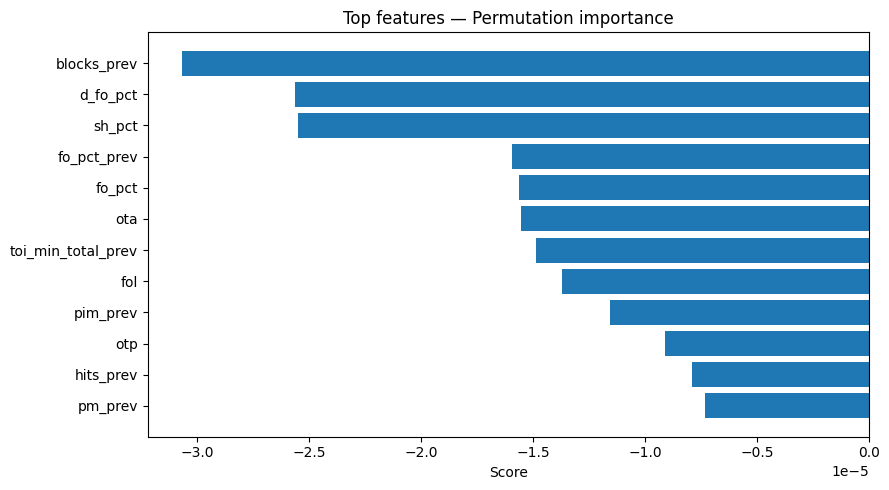

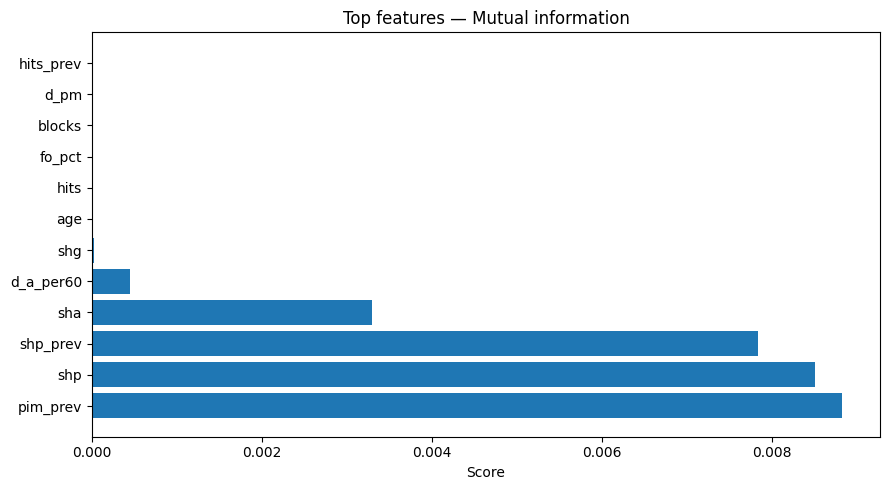

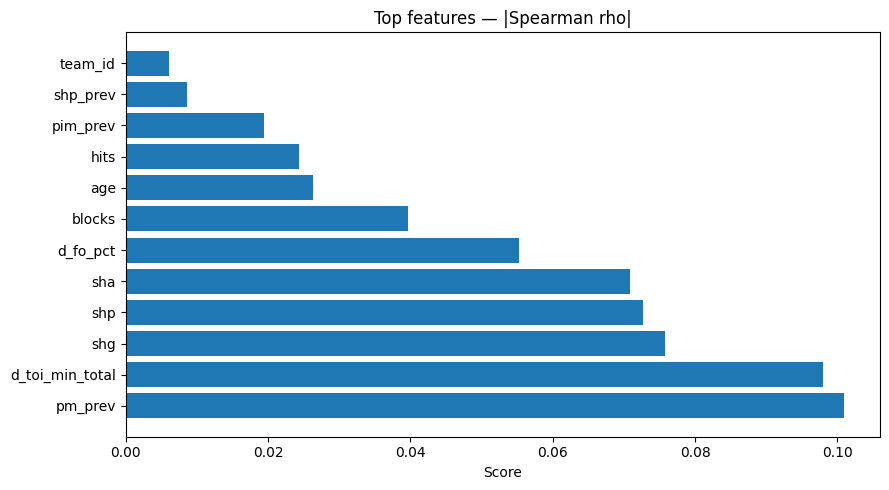

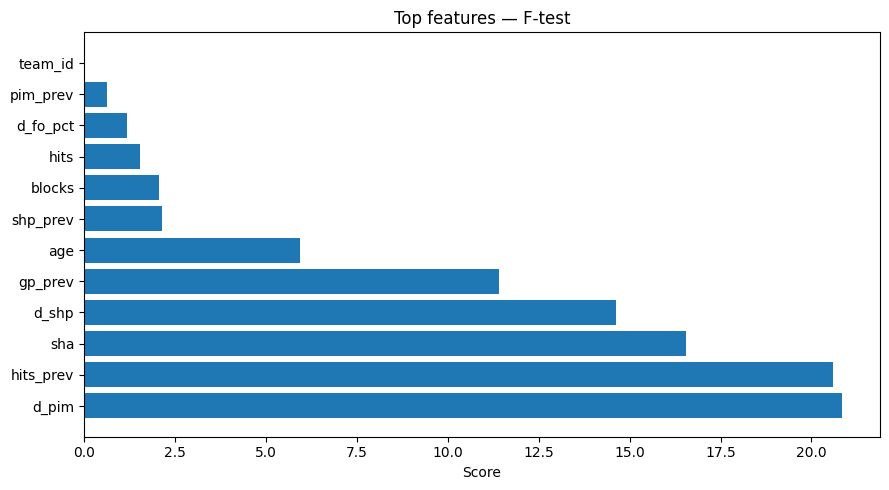

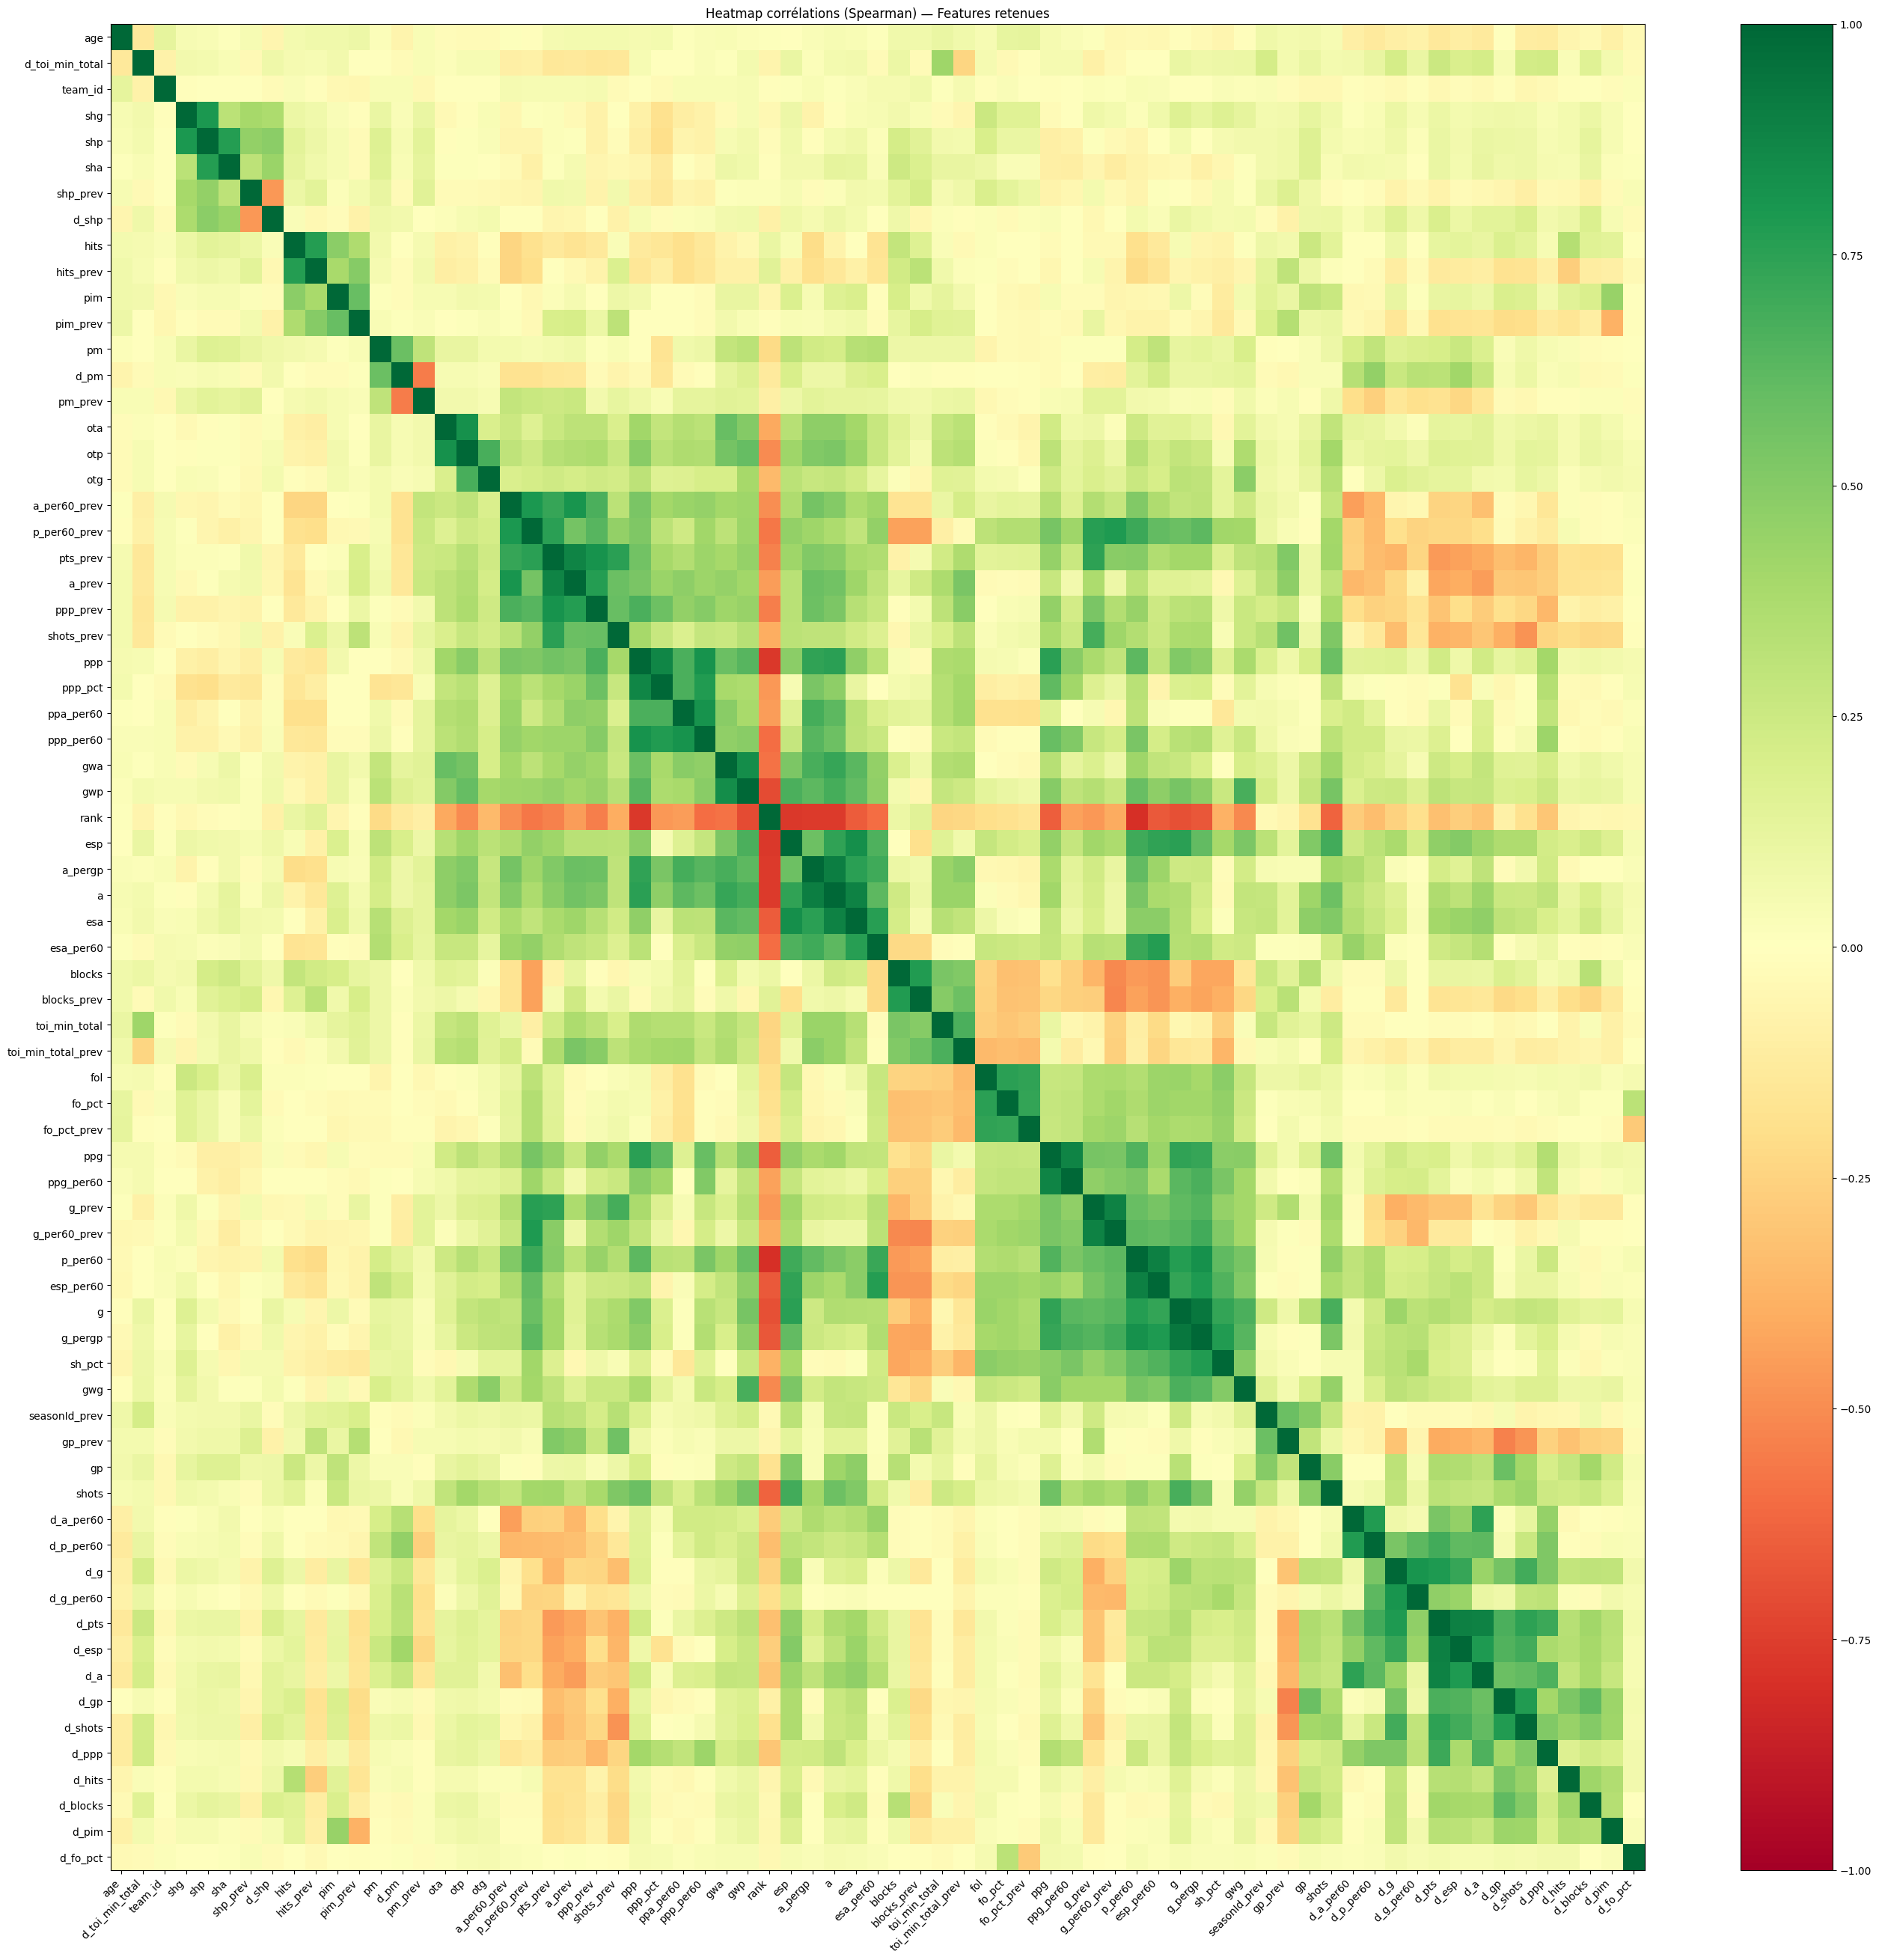

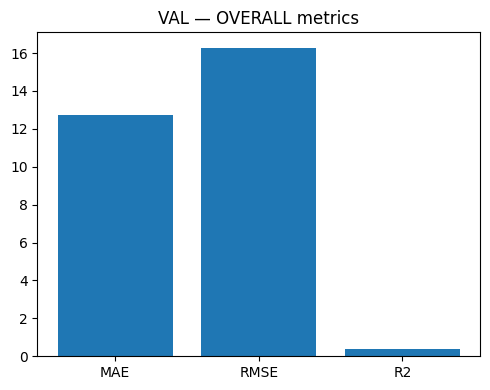

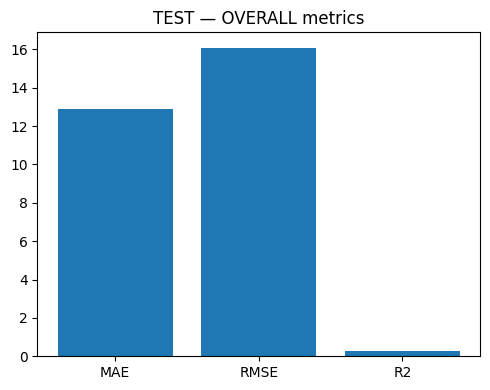

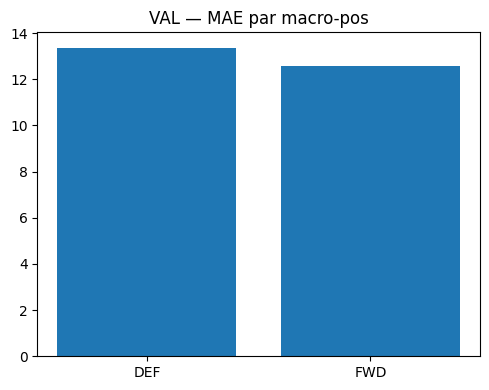

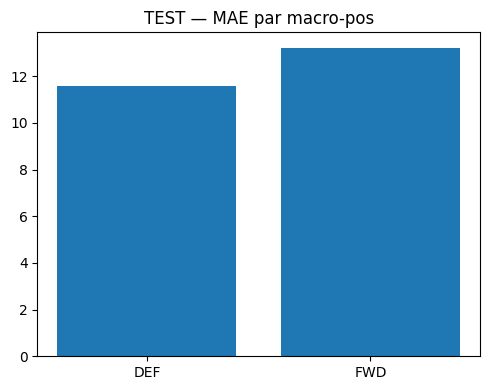

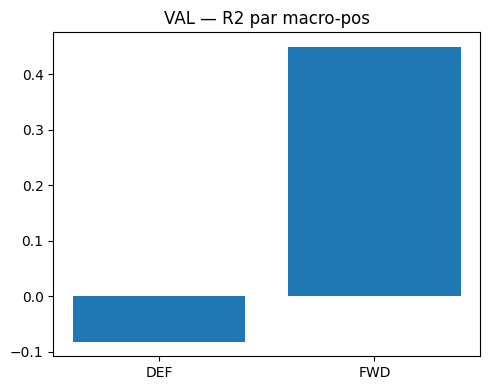

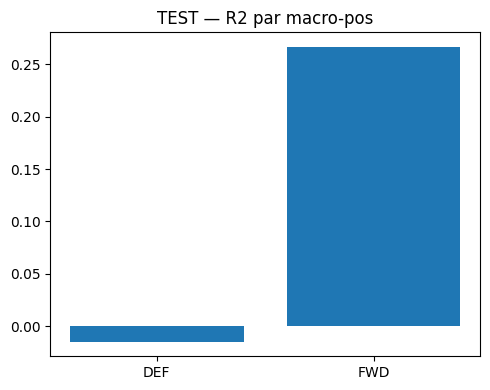

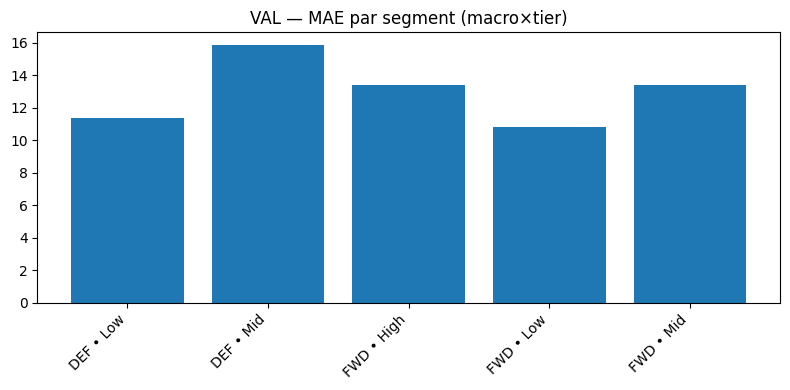

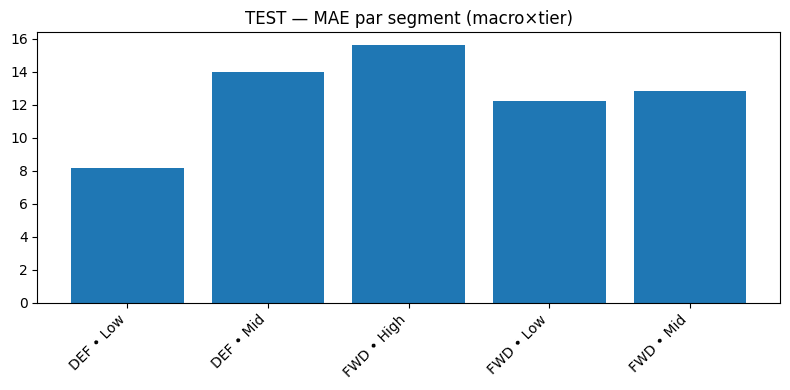

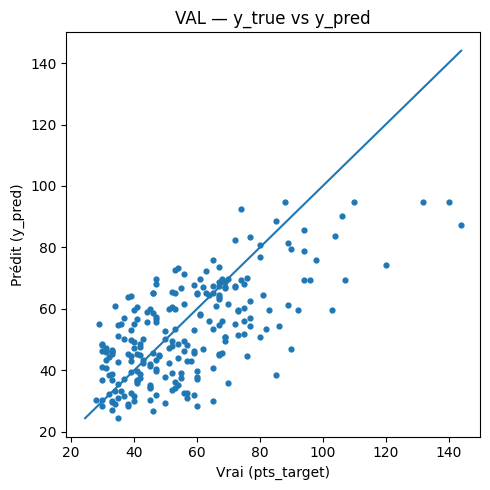

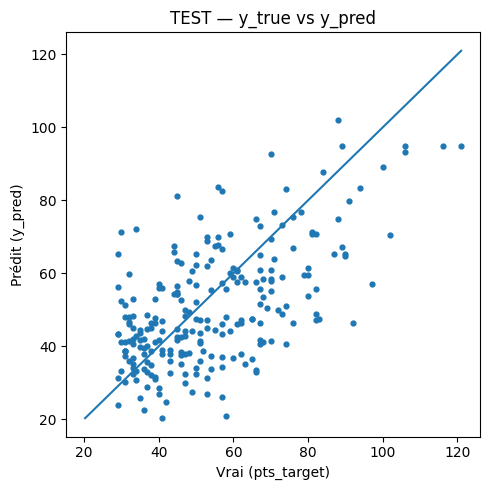

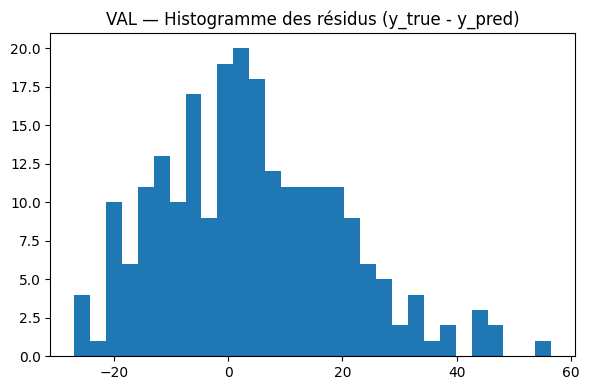

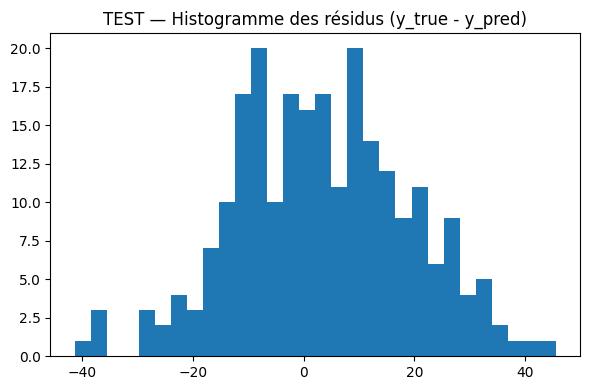

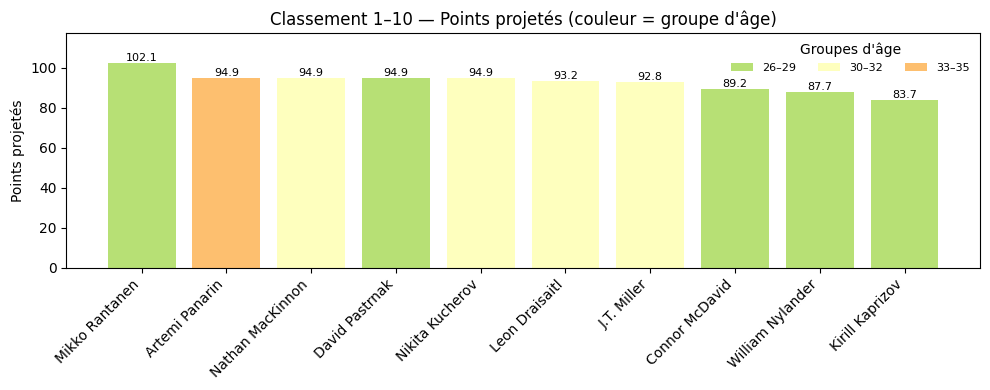

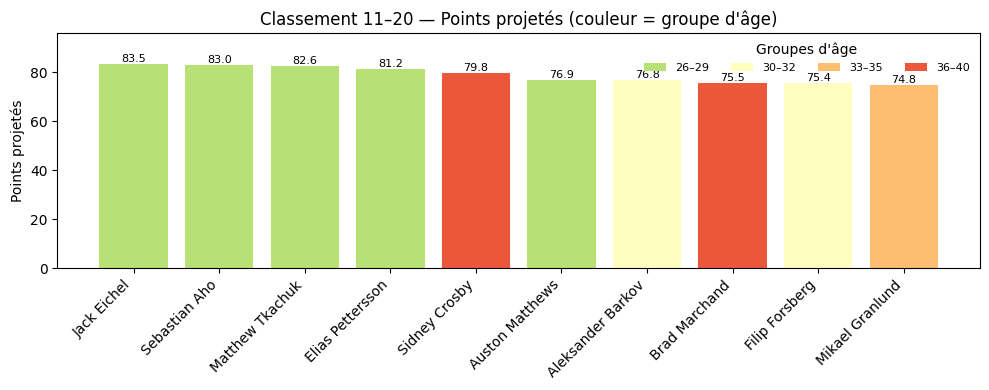

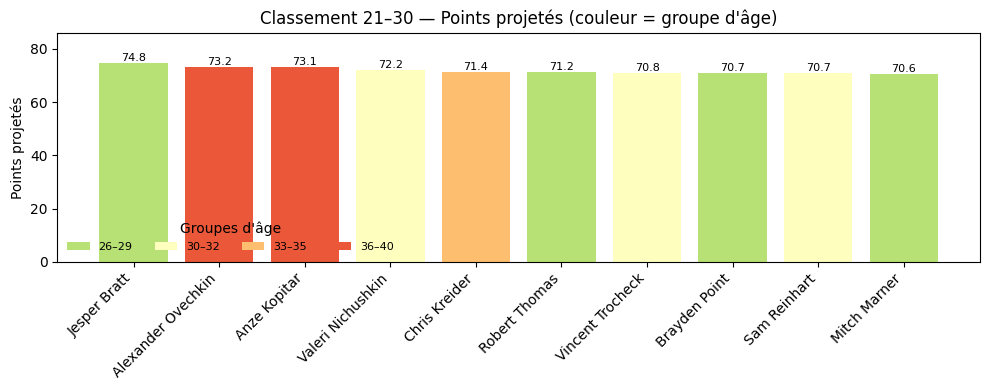

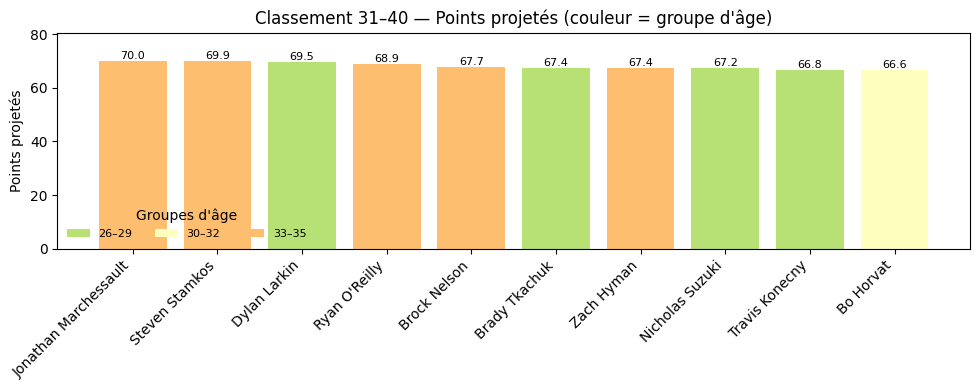

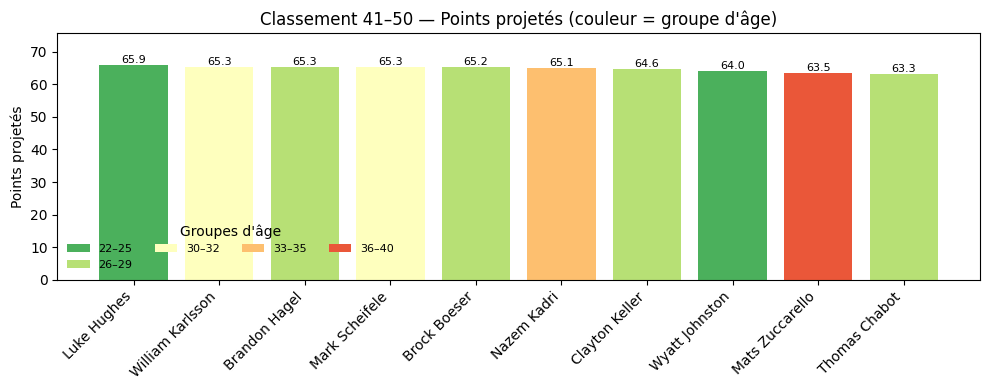

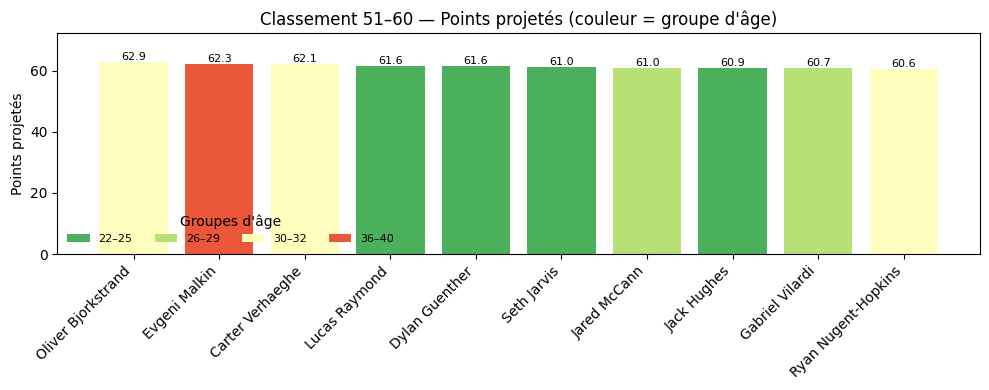

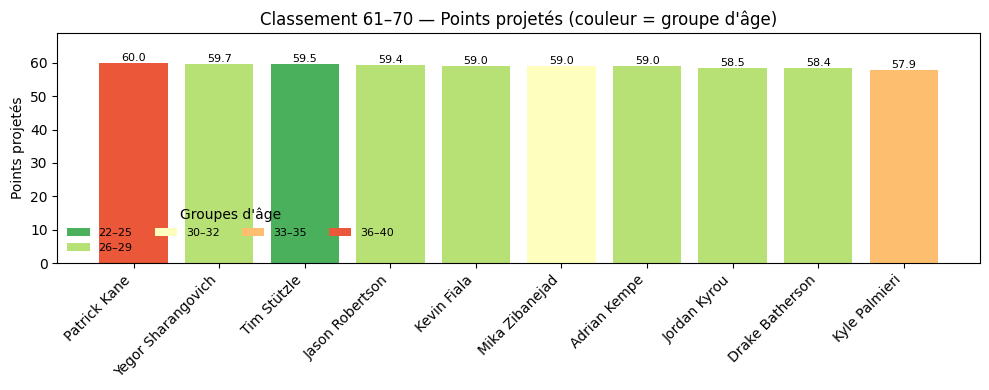

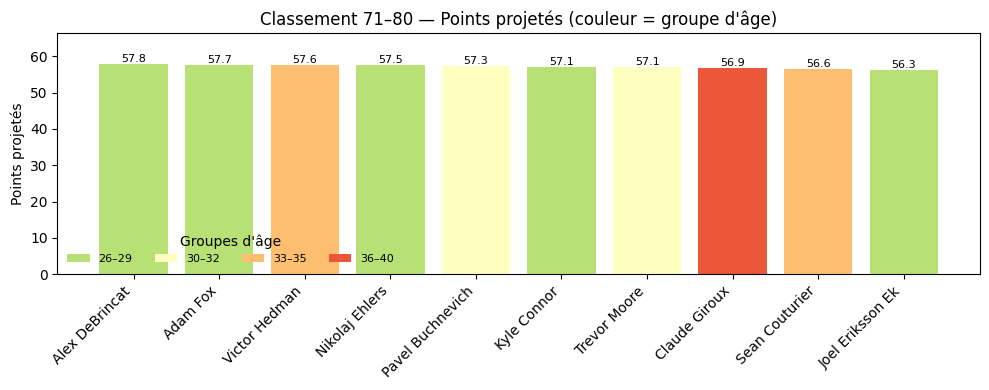

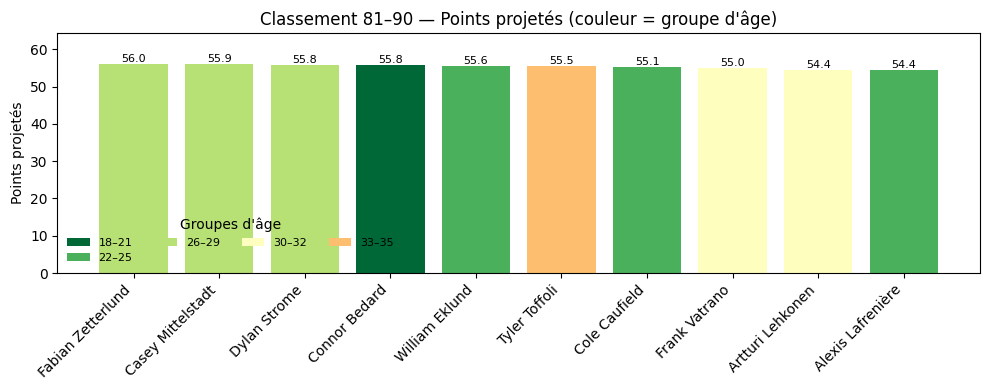

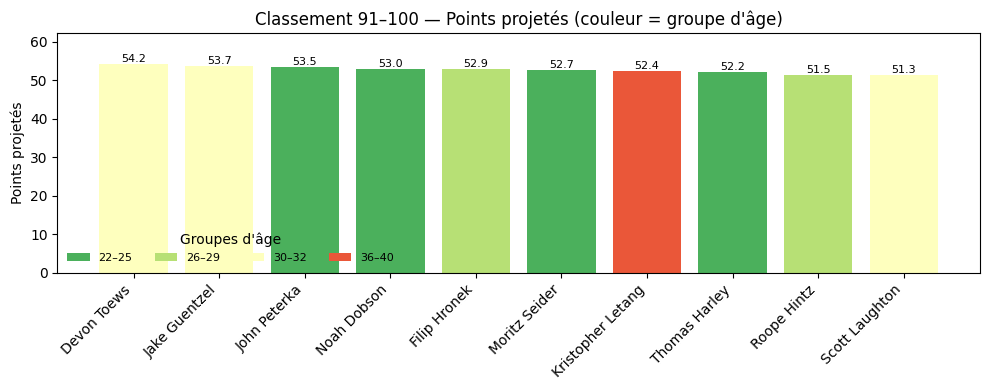

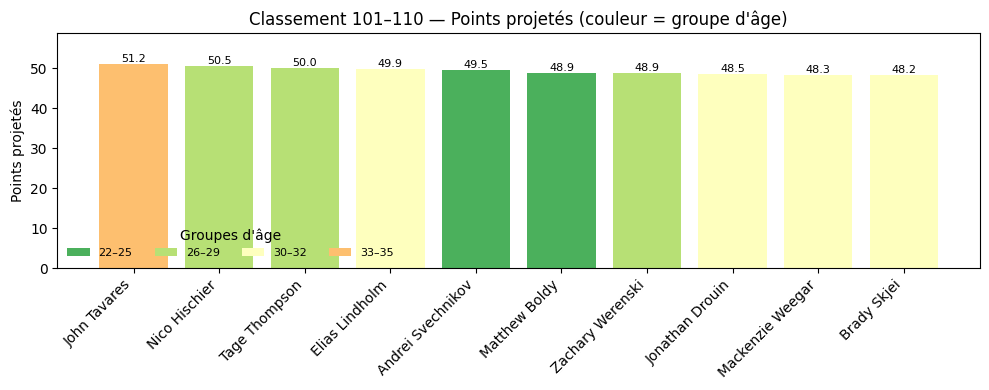

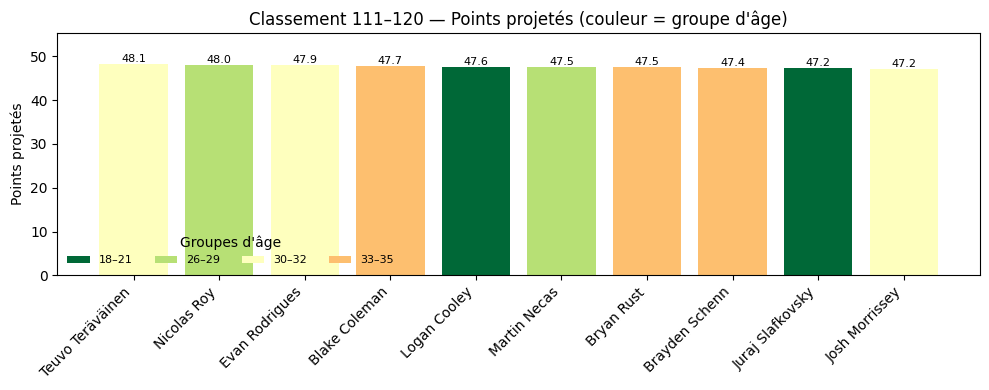

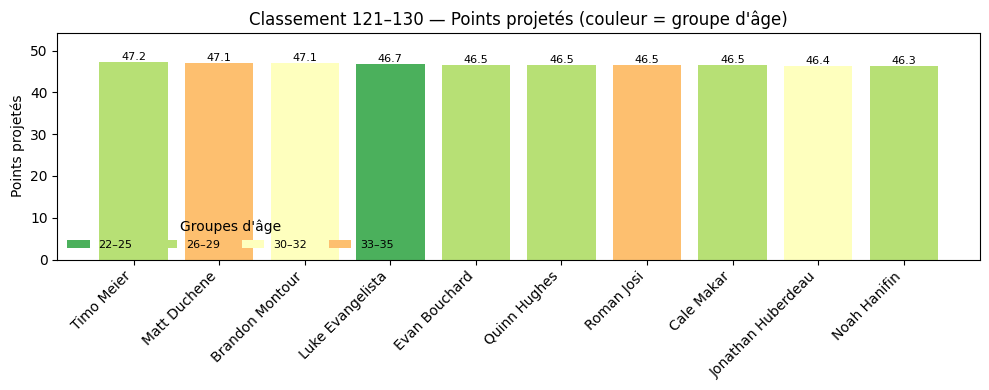

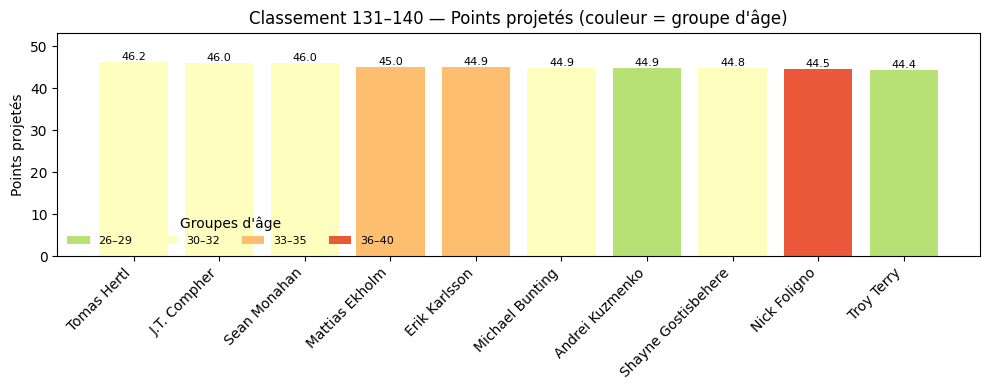

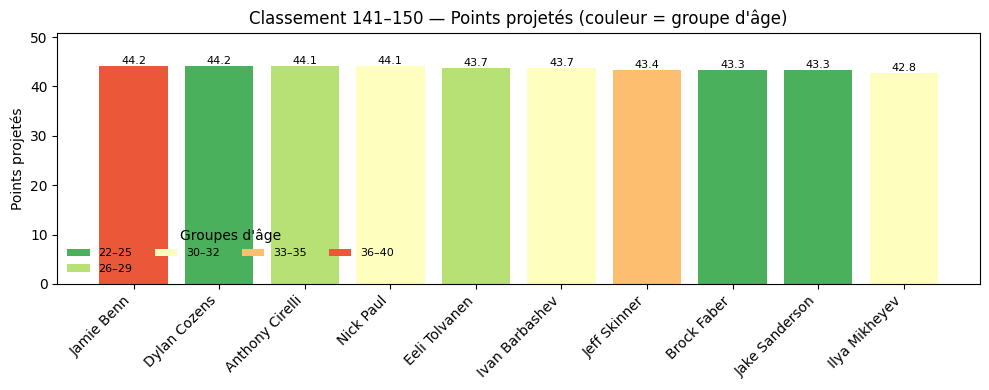

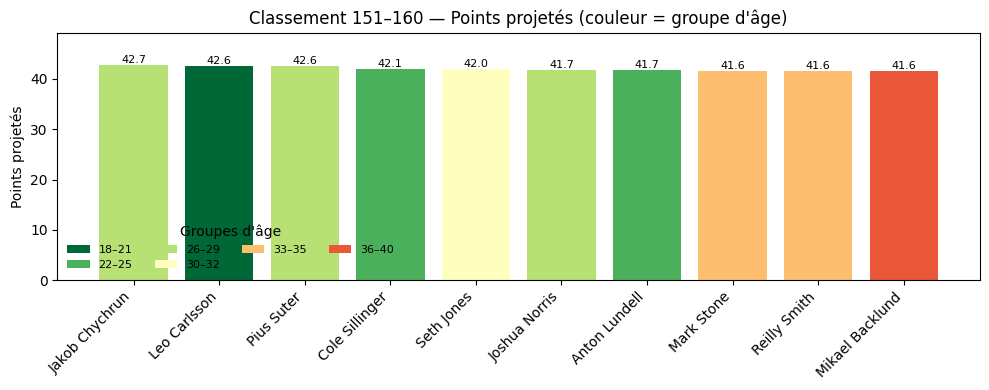

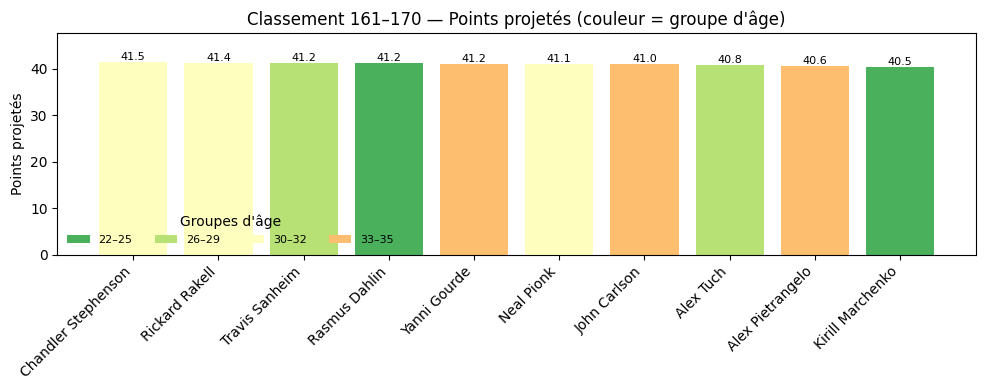

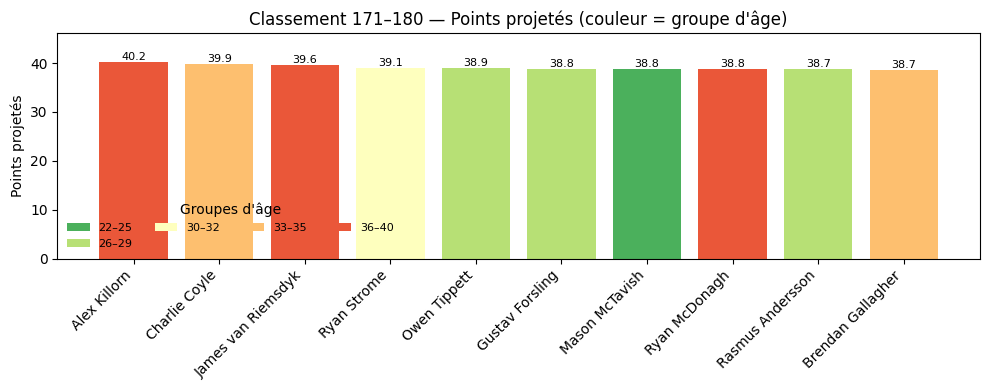

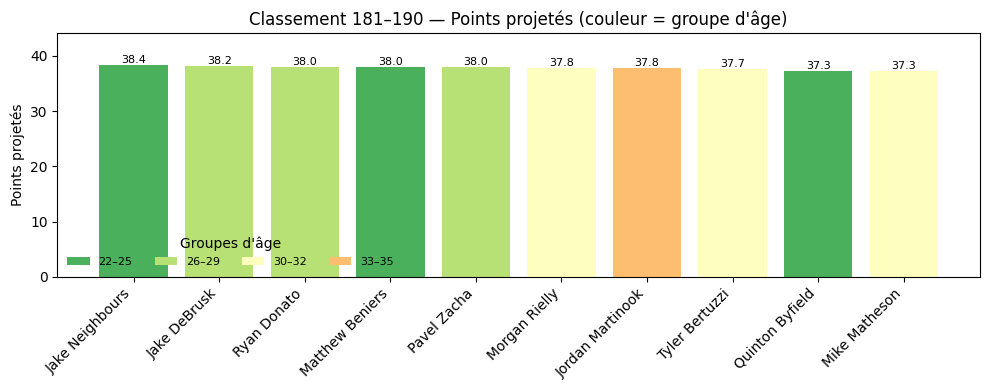

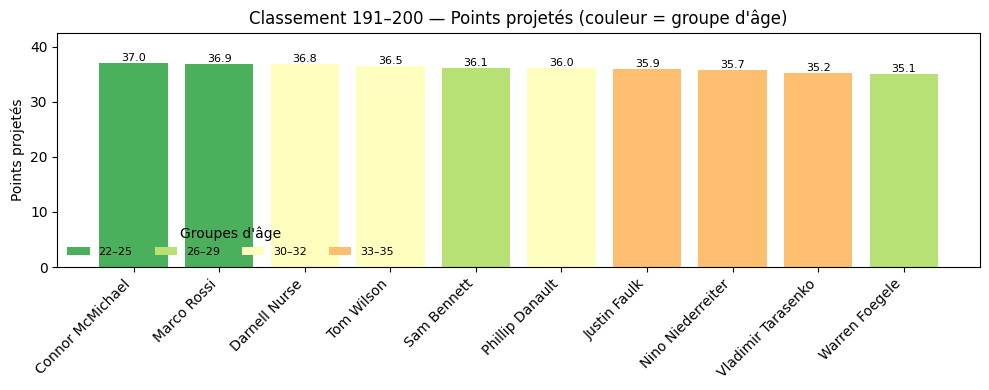

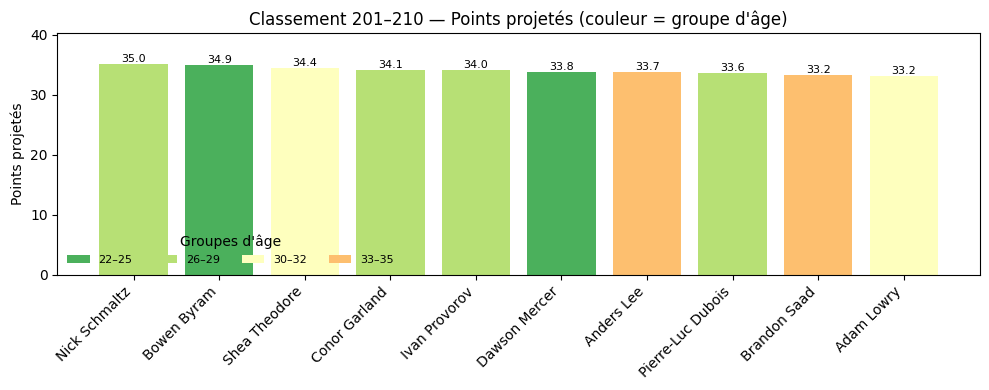

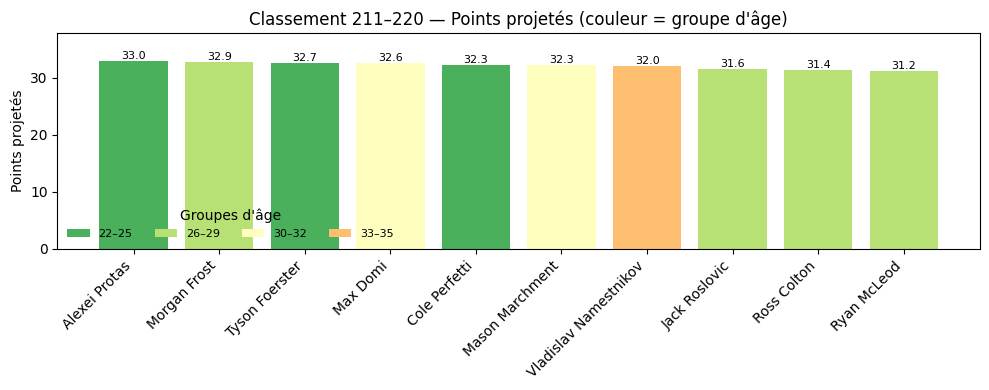

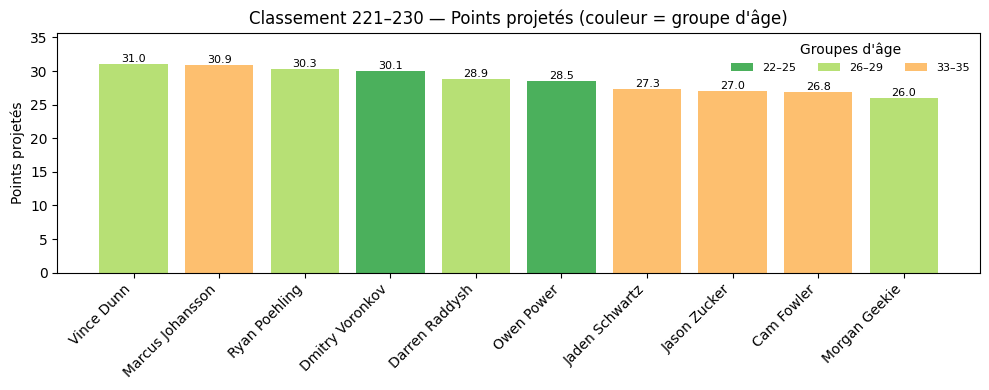

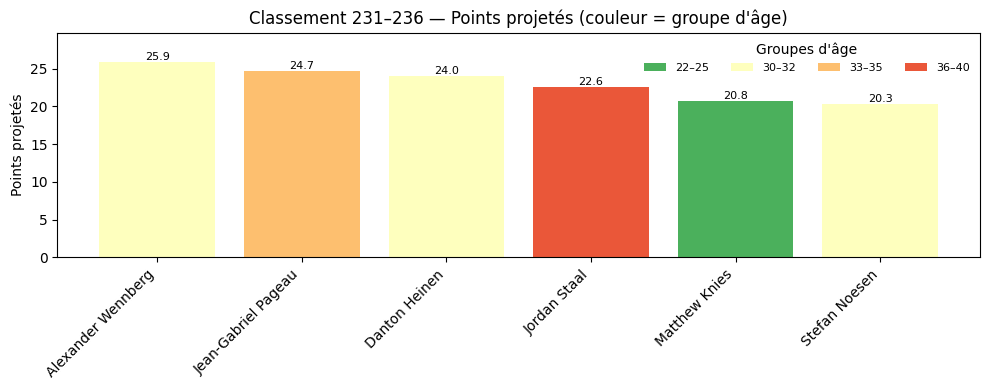

[OK] Excel écrit -> C:\Users\cedri\OneDrive\SCI1402_PROJET_FINAL\artifacts_models/projections_202526_avec_historiques.xlsx
[OK] PDF des graphiques enregistré -> C:\Users\cedri\OneDrive\SCI1402_PROJET_FINAL\artifacts_models/rapport_graphs_bloc6.pdf


In [103]:
# ============================================
#  AFFICHAGES : sélection de variables & résultats finaux
#  (Colab-ready | matplotlib only | 1 plot/figure)
# ============================================
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.backends.backend_pdf import PdfPages

# ---------- HELPERS PATHS (robustes) ----------
def first_existing(paths, label=""):
    for p in paths:
        if p and os.path.exists(p):
            print(f"[OK] {label} -> {p}")
            return p
    print(f"[Info] Aucun chemin trouvé pour {label}. Essayé: {paths}")
    return None

# Dossiers possibles (adapte si tu changes plus tard)
FEAT_DIR = first_existing([
    "featuredselect",
    os.path.join("C:\\Users\\cedri\\OneDrive\\SCI1402_PROJET_FINAL","featuredselect"),
    os.path.join("C:\\Users\\cedri\\OneDrive\\SCI1402_PROJET_FINAL","artifacts_featselect"),
    "artifacts_featselect",
], label="FEAT_DIR")

MODEL_DIR = first_existing([
    r"C:\Users\cedri\OneDrive\SCI1402_PROJET_FINAL\artifacts_models",
    "artifacts_models",
    os.path.join("C:\\Users\\cedri\\OneDrive\\SCI1402_PROJET_FINAL","artifacts_models"),
], label="MODEL_DIR")

# ---------- FICHIERS ----------
def pjoin_safe(base, fname):
    return None if base is None else os.path.join(base, fname)

FS_WIDE_CSV   = pjoin_safe(FEAT_DIR,  "feature_scores_wide.csv")
FS_LONG_CSV   = pjoin_safe(FEAT_DIR,  "feature_scores_long.csv")
FEAT_REP_CSV  = pjoin_safe(FEAT_DIR,  "selected_features_by_corr_clustering.csv")

MET_VAL_CSV   = pjoin_safe(MODEL_DIR, "metrics_val.csv")
MET_TEST_CSV  = pjoin_safe(MODEL_DIR, "metrics_test.csv")
PRED_VAL_CSV  = pjoin_safe(MODEL_DIR, "predictions_val.csv")
PRED_TEST_CSV = pjoin_safe(MODEL_DIR, "predictions_test.csv")

TOP_N = 12  # nombre de features à montrer dans les barres

# ---------- LOAD SAFE ----------
def safe_read_csv(path, **kwargs):
    if path and os.path.exists(path):
        return pd.read_csv(path, **kwargs)
    print(f"[Info] Fichier introuvable: {path}")
    return None

fs_wide  = safe_read_csv(FS_WIDE_CSV)
fs_long  = safe_read_csv(FS_LONG_CSV)
feat_rep = safe_read_csv(FEAT_REP_CSV, header=None, names=["feature"])

met_val  = safe_read_csv(MET_VAL_CSV)
met_test = safe_read_csv(MET_TEST_CSV)
pred_val = safe_read_csv(PRED_VAL_CSV)
pred_test= safe_read_csv(PRED_TEST_CSV)

# ---------- PDF COLLECTOR ----------
if MODEL_DIR is None:
    MODEL_DIR = "."
PDF_PATH = os.path.join(MODEL_DIR, "rapport_graphs_bloc6.pdf")
pdf = PdfPages(PDF_PATH)

def add_page(fig=None):
    """Sauve la figure courante (ou donnée) dans le PDF."""
    try:
        if fig is None:
            fig = plt.gcf()
        pdf.savefig(fig, bbox_inches='tight')
    except Exception as _e:
        pass

# =========================================================
#  A) GRAPHIQUES — Sélection de variables
# =========================================================
def bar_top_from_long(df_long, metric_name, title, top_n=TOP_N, ascending=False):
    if df_long is None or df_long.empty:
        print(f"[Info] Pas de données pour {title}")
        return
    d = df_long[df_long["metric"] == metric_name].copy()
    if d.empty:
        print(f"[Info] Metric '{metric_name}' absente.")
        return
    d["score_plot"] = d["score"].abs() if metric_name == "spearman_rho" else d["score"]
    d = d.sort_values("score_plot", ascending=ascending).tail(top_n)
    plt.figure(figsize=(9, 5))
    plt.barh(d["feature"], d["score_plot"])
    plt.xlabel("Score")
    plt.title(title)
    plt.tight_layout()
    add_page()
    plt.show()

# 1) Permutation importance
bar_top_from_long(fs_long, "perm_importance", "Top features — Permutation importance")

# 2) Mutual information
bar_top_from_long(fs_long, "mutual_info", "Top features — Mutual information")

# 3) Spearman |rho|
bar_top_from_long(fs_long, "spearman_rho", "Top features — |Spearman rho|")

# 4) F-test
bar_top_from_long(fs_long, "f_test", "Top features — F-test")

# 5) Heatmap corrélation (GLOBAL) sur les features représentantes (si df en RAM)
try:
    if feat_rep is not None and "df" in globals():
        feats = [f for f in feat_rep["feature"].tolist() if f in df.columns]
        if len(feats) >= 2:
            Xcorr = df[feats].corr(method="spearman", numeric_only=True)
            plt.figure(figsize=(6 + 0.3*len(feats), 5 + 0.3*len(feats)))
            plt.imshow(Xcorr, aspect="auto", cmap="RdYlGn", vmin=-1, vmax=1)  # rouge->vert
            plt.xticks(ticks=range(len(feats)), labels=feats, rotation=45, ha="right")
            plt.yticks(ticks=range(len(feats)), labels=feats)
            plt.title("Heatmap corrélations (Spearman) — Features retenues")
            plt.colorbar()
            plt.tight_layout()
            add_page()
            plt.show()
        else:
            print("[Info] Trop peu de features retenues pour la heatmap.")
    else:
        print("[Info] Heatmap ignorée (feat_rep ou df non disponible).")
except Exception as e:
    print("[Info] Heatmap non tracée:", e)

# =========================================================
#  B) GRAPHIQUES — Résultats finaux (val/test)
# =========================================================
def plot_metrics_overall(met_df, split_name):
    if met_df is None or met_df.empty:
        print(f"[Info] metrics {split_name} indisponible")
        return
    d = met_df[met_df["level"] == "OVERALL"].copy()
    if d.empty:
        print(f"[Info] Pas de ligne OVERALL pour {split_name}")
        return
    row = d.iloc[0]
    names = ["MAE","RMSE","R2"]
    vals  = [row.get("MAE", np.nan), row.get("RMSE", np.nan), row.get("R2", np.nan)]
    plt.figure(figsize=(5,4))
    plt.bar(names, vals)
    plt.title(f"{split_name.upper()} — OVERALL metrics")
    plt.tight_layout()
    add_page()
    plt.show()

def plot_metrics_macro(met_df, split_name, metric="MAE"):
    if met_df is None or met_df.empty:
        print(f"[Info] metrics {split_name} indisponible")
        return
    d = met_df[met_df["level"] == "MACRO"].copy()
    if d.empty:
        print(f"[Info] Pas de lignes MACRO pour {split_name}")
        return
    d = d.sort_values("macro_pos")
    plt.figure(figsize=(5,4))
    plt.bar(d["macro_pos"], d[metric])
    plt.title(f"{split_name.upper()} — {metric} par macro-pos")
    plt.tight_layout()
    add_page()
    plt.show()

def plot_metrics_segments(met_df, split_name, metric="MAE"):
    if met_df is None or met_df.empty:
        print(f"[Info] metrics {split_name} indisponible")
        return
    d = met_df[met_df["level"] == "SEG"].copy()
    if d.empty:
        print(f"[Info] Pas de lignes SEGMENT pour {split_name} (petits n ou fallback global).")
        return
    d["key"] = d["macro_pos"].astype(str) + " • " + d["tier"].astype(str)
    d = d.sort_values(["macro_pos","tier"])
    plt.figure(figsize=(8,4))
    plt.bar(d["key"], d[metric])
    plt.xticks(rotation=45, ha="right")
    plt.title(f"{split_name.upper()} — {metric} par segment (macro×tier)")
    plt.tight_layout()
    add_page()
    plt.show()

# 6) OVERALL (val & test)
plot_metrics_overall(met_val, "val")
plot_metrics_overall(met_test, "test")

# 7) MACRO FWD/DEF (val & test) — MAE puis R2
plot_metrics_macro(met_val, "val", metric="MAE")
plot_metrics_macro(met_test, "test", metric="MAE")

plot_metrics_macro(met_val, "val", metric="R2")
plot_metrics_macro(met_test, "test", metric="R2")

# 8) SEGMENTS (macro×tier) si disponibles
plot_metrics_segments(met_val, "val", metric="MAE")
plot_metrics_segments(met_test, "test", metric="MAE")

# 9) Nuages y_true vs y_pred (val & test)
def scatter_true_pred(pred_df, split_name):
    if pred_df is None or pred_df.empty or "pts_target" not in pred_df.columns or "y_pred" not in pred_df.columns:
        print(f"[Info] predictions {split_name} indisponible ou colonnes manquantes")
        return
    plt.figure(figsize=(5,5))
    plt.scatter(pred_df["pts_target"], pred_df["y_pred"], s=12)
    mn = float(np.nanmin([pred_df["pts_target"].min(), pred_df["y_pred"].min()]))
    mx = float(np.nanmax([pred_df["pts_target"].max(), pred_df["y_pred"].max()]))
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("Vrai (pts_target)")
    plt.ylabel("Prédit (y_pred)")
    plt.title(f"{split_name.upper()} — y_true vs y_pred")
    plt.tight_layout()
    add_page()
    plt.show()

scatter_true_pred(pred_val, "val")
scatter_true_pred(pred_test, "test")

# 10) Histogrammes des résidus (val & test)
def hist_residuals(pred_df, split_name):
    if pred_df is None or pred_df.empty or "pts_target" not in pred_df.columns or "y_pred" not in pred_df.columns:
        print(f"[Info] predictions {split_name} indisponible ou colonnes manquantes")
        return
    res = pred_df["pts_target"] - pred_df["y_pred"]
    plt.figure(figsize=(6,4))
    plt.hist(res.dropna().values, bins=30)
    plt.title(f"{split_name.upper()} — Histogramme des résidus (y_true - y_pred)")
    plt.tight_layout()
    add_page()
    plt.show()

hist_residuals(pred_val, "val")
hist_residuals(pred_test, "test")

# =========================================================
#  C) PROJECTIONS — 25 graphiques (10 joueurs/graph) + Excel
#     • barres colorées par groupe d'âge (vert foncé -> rouge foncé)
#     • data labels = points projetés
#     • ajout des figures au PDF
# =========================================================
def find_latest_predictions_next(model_dir):
    if not model_dir or not os.path.exists(model_dir):
        return None
    files = [f for f in os.listdir(model_dir) if f.startswith("predictions_next_") and f.endswith(".csv")]
    if not files:
        return None
    seasons = []
    for f in files:
        m = re.search(r'predictions_next_(\d+)\.csv$', f)
        if m:
            seasons.append((int(m.group(1)), f))
    if seasons:
        seasons.sort()
        return os.path.join(model_dir, seasons[-1][1])
    return os.path.join(model_dir, files[0])

pred_next_path = find_latest_predictions_next(MODEL_DIR)
pred_next = safe_read_csv(pred_next_path)

if pred_next is None or pred_next.empty:
    print("[Info] Aucune prédiction 'predictions_next_*.csv' trouvée.")
else:
    # ---- Déduire saisons next/test/prev à partir du nom de fichier
    m = re.search(r'predictions_next_(\d+)\.csv$', os.path.basename(pred_next_path))
    next_season = int(m.group(1)) if m else None
    test_season = next_season - 101 if next_season else None   # ex.: 202526 -> 202425
    prev_season = test_season - 101 if test_season else None   # ex.: 202425 -> 202324

    # ---- Ajoute l'âge pour la saison suivante (âge de la saison test + 1), si df dispo
    pred_enriched = pred_next.copy()
    if "df" in globals() and test_season is not None and "age" in df.columns:
        ages = (df[df["seasonId"] == test_season][["playerName", "age"]]
                .drop_duplicates())
        ages["age_next"] = pd.to_numeric(ages["age"], errors="coerce") + 1
        pred_enriched = pred_enriched.merge(ages[["playerName","age_next"]], on="playerName", how="left")
    else:
        pred_enriched["age_next"] = np.nan

    # ---- Groupes d'âge
    def age_band_fn(a):
        if pd.isna(a): return "N/A"
        a = int(a)
        if a <= 21: return "18–21"
        elif a <= 25: return "22–25"
        elif a <= 29: return "26–29"
        elif a <= 32: return "30–32"
        elif a <= 35: return "33–35"
        elif a <= 40: return "36–40"
        else: return "40+"

    pred_enriched["age_band"] = pred_enriched["age_next"].apply(age_band_fn)
    band_order = ["18–21","22–25","26–29","30–32","33–35","36–40","40+"]

    # Palette rouge→vert: plus jeune = vert foncé, plus vieux = rouge foncé
    cmap = plt.cm.get_cmap("RdYlGn")  # 0=rouge ... 1=vert
    band_to_color = {b: cmap(v) for b, v in zip(band_order, np.linspace(1, 0, len(band_order)))}
    fallback_grey = (0.6, 0.6, 0.6, 1.0)

    # ---- Classement global & groupes de 10
    topN = min(250, len(pred_enriched))
    top = (pred_enriched.sort_values("y_pred", ascending=False)
           .head(topN).reset_index(drop=True))
    top["rank"]  = np.arange(1, len(top)+1)
    top["group"] = ((top["rank"] - 1) // 10) + 1  # 10 joueurs / figure

    # ---- 25 graphiques (ou moins si <250 joueurs)
    num_groups = int(top["group"].max())
    for g in range(1, min(25, num_groups) + 1):
        sg = top[top["group"] == g]
        colors = [band_to_color.get(b, fallback_grey) for b in sg["age_band"]]

        plt.figure(figsize=(10, 4))
        bars = plt.bar(sg["playerName"], sg["y_pred"], color=colors)

        # Data labels (points projetés)
        ymax = float(sg["y_pred"].max()) if len(sg) else 0.0
        for bar, val in zip(bars, sg["y_pred"]):
            plt.text(bar.get_x() + bar.get_width()/2,
                     bar.get_height(),
                     f"{val:.1f}",
                     ha="center", va="bottom", fontsize=8)
        plt.ylim(0, max(1.0, ymax*1.15))  # marge pour afficher les labels

        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Points projetés")
        r1 = (g-1)*10 + 1; r2 = min(g*10, topN)
        plt.title(f"Classement {r1}–{r2} — Points projetés (couleur = groupe d'âge)")

        # Légende (groupes d'âge présents)
        present_bands = [b for b in band_order if b in sg["age_band"].unique()]
        handles = [Patch(facecolor=band_to_color[b], label=b) for b in present_bands]
        if handles:
            plt.legend(handles=handles, title="Groupes d'âge", ncol=4, frameon=False, fontsize=8)

        plt.tight_layout()
        add_page()  # <-- ajoute au PDF
        plt.show()

    # ---- Excel: nom, âge (next), points projetés, points 2025 & 2024 (réels si dispo)
    def actual_pts(df_base, season_id):
        return (df_base[df_base["seasonId"] == season_id][["playerName", "pts"]]
                .drop_duplicates()
                .rename(columns={"pts": f"pts_{season_id}"}))

    out = top.copy()

    # Ajoute âges (next) si pas déjà fait
    if "age_next" not in out.columns:
        out["age_next"] = np.nan

    # Points réels 2025 (2024-25) & 2024 (2023-24)
    if "df" in globals() and test_season is not None:
        out = out.merge(actual_pts(df, test_season), on="playerName", how="left")
    if "df" in globals() and prev_season is not None:
        out = out.merge(actual_pts(df, prev_season), on="playerName", how="left")

    # Renommer joliment
    def endyear_label(season_id):
        s = str(season_id)
        return 2000 + int(s[-2:])  # 202425 -> 2025

    col_2025 = f"pts_{test_season}" if test_season is not None else None
    col_2024 = f"pts_{prev_season}" if prev_season is not None else None
    rename_map = {"y_pred": "points_projetes", "age_next": "age"}
    if col_2025 and col_2025 in out.columns:
        rename_map[col_2025] = f"points_{endyear_label(test_season)}"
    if col_2024 and col_2024 in out.columns:
        rename_map[col_2024] = f"points_{endyear_label(prev_season)}"

    out_final = out.rename(columns=rename_map)

    keep_cols = ["playerName", "age", "points_projetes"]
    if f"points_{endyear_label(test_season)}" in out_final.columns:
        keep_cols.append(f"points_{endyear_label(test_season)}")
    if f"points_{endyear_label(prev_season)}" in out_final.columns:
        keep_cols.append(f"points_{endyear_label(prev_season)}")
    out_final = out_final[keep_cols]

    excel_path = os.path.join(MODEL_DIR, f"projections_{next_season}_avec_historiques.xlsx")
    try:
        with pd.ExcelWriter(excel_path, engine="xlsxwriter") as xl:
            out_final.to_excel(xl, "projections", index=False)
        print(f"[OK] Excel écrit -> {excel_path}")
    except Exception as e:
        print("[Info] Excel non écrit:", e)

# ---------- FIN PDF ----------
try:
    pdf.close()
    print(f"[OK] PDF des graphiques enregistré -> {PDF_PATH}")
except Exception as e:
    print("[Info] PDF non écrit:", e)
